# Final Project Submission

* **Student name**: Sara Robinson
* **Student pace**: *self paced*/part time/full time
* **Scheduled project review date/time**: 10/29/2021 18:00
* **Instructor name**: Jeff Herman
* **Project Reviewer**: James Irving
* **Notebook**: 4/4

# Introduction

The purpose of this project is to do a thorough exploratory data analysis of the characters and scripts of the TV show How I Met Your Mother, as well as create a model that can predict who said which line. The data is from the website https://transcripts.foreverdreaming.org/viewforum.php?f=177 where there are nine pages containing the 208 episodes from nine seasons that the show ran.

This is the fourth notebook for my Capstone Project. This notebook contains the modeling portion of this project. The models will be attempting to predict which character said which line.

## Import Libraries

In the following cell I import the necessary libraries for this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
import project_functions
from project_functions import *

## Load and Inspect Data

In the following cells I load the dataset we prepared in the previous notebook to be modeled and make sure everything is ready to go.

In [2]:
df = pd.read_csv('ModelDF.csv') #Read in dataset
df.head() #Checking first 5 rows

Character                                               Line  \
0  Marshall                                  will you marry me   
1       Ted  yes perfect and then youre engaged you pop the...   
2  Marshall     got it thanks for helping me plan this out ted   
3       Ted  dude are you kidding its you and lily ive been...   
4  Marshall              yeah sorry we thought you were asleep   

                                              Tokens  
0                                          ['marry']  
1  ['perfect', 'engaged', 'pop', 'champagne', 'dr...  
2               ['thanks', 'helping', 'plan', 'ted']  
3  ['dude', 'kidding', 'lily', 'big', 'moments', ...  
4                     ['sorry', 'thought', 'asleep']

In [3]:
df.info() #Making sure everything loaded correctly

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21995 entries, 0 to 21994
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Character  21995 non-null  object
 1   Line       21981 non-null  object
 2   Tokens     21995 non-null  object
dtypes: object(3)
memory usage: 515.6+ KB


There appears to be some lines missing, let's take a quick look and determine if those rows need to be removed.

In [4]:
df[df['Line'].isnull()]

Character Line   Tokens
56         Lily  NaN  ['nan']
339         Ted  NaN  ['nan']
953    Marshall  NaN       []
5879        Ted  NaN       []
7093     Barney  NaN       []
7108     Barney  NaN       []
8589       Lily  NaN       []
11571      Lily  NaN       []
11573      Lily  NaN       []
11576    Barney  NaN       []
12485     Robin  NaN       []
12527       Ted  NaN       []
16849     Robin  NaN       []
18777    Barney  NaN       []

Since there aren't that many null entries (probably due to removing stopwords), I will just go ahead and remove these entries and continue.

In [5]:
df.dropna(subset = ['Line'], inplace = True) #Dropping null entries
df.info() #Checking info again

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21981 entries, 0 to 21994
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Character  21981 non-null  object
 1   Line       21981 non-null  object
 2   Tokens     21981 non-null  object
dtypes: object(3)
memory usage: 686.9+ KB


Great! Now that everything is even, we're going to convert the clean token column from a list of strings as a string to just a list of strings, then we'll prepare everything to model.

In [6]:
df['Tokens'] = df['Tokens'].map(ast.literal_eval) #converting list of strings as string to list of strings

df.head() #Checking df

Character                                               Line  \
0  Marshall                                  will you marry me   
1       Ted  yes perfect and then youre engaged you pop the...   
2  Marshall     got it thanks for helping me plan this out ted   
3       Ted  dude are you kidding its you and lily ive been...   
4  Marshall              yeah sorry we thought you were asleep   

                                              Tokens  
0                                            [marry]  
1  [perfect, engaged, pop, champagne, drink, toas...  
2                       [thanks, helping, plan, ted]  
3  [dude, kidding, lily, big, moments, lily, nigh...  
4                           [sorry, thought, asleep]

# Preparing to Model

Before we can model the data, we need to perform a train test split and split the data into training and test sets. I am going to quickly put all of my functions for modeling above all of this to keep them together.

In [7]:
from matplotlib import rcParams
import matplotlib.font_manager
import matplotlib.font_manager as font_manager

rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

font_dir = ['/Users/robotrobz/Downloads/Dax Regular']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
rcParams['font.family'] = 'Dax'

In [8]:
X = df['Tokens'] #Setting X
y = df['Character'] #Setting y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, 
                                                   random_state = 56, stratify = df['Character']) #Splitting data

display(X_train.shape) #Checking shape of X_train
display(y_train.shape) #Checking shape of y_train
display(X_test.shape) #Checking shape of X_test
display(y_test.shape) #Checking shape of y_test

(14727,)

(14727,)

(7254,)

(7254,)

Great! We're all set up and ready to start modeling.

# Baseline Modeling

Things might get a little messy here because I will be usig both the Count Vectorizer and TF-IDF Vectorizer so I can compare the two on each model I run so I can truly determine which performs best. Here are the baseline models I will be running:

* Logistic Regression
* Multinomial Naive Bayes
* K Nearest Neighbors
* Random Forest
* Decision Tree
* AdaBoost

There will be 12 baseline models to look at since there will be two vectorizers for each model. For now, none of the parameters within any model will be changed, that will be saved for tuning later on. As I go through I'll be creating a new datarame that will contain the accuracy scores, precision scores, recall scores, F1 scores, Cohen's Kappa scores, Matthew's Correlation Coefficients, precision recall curve auc scores, and receiver operating characteristic auc scores. This way I can truly determine which models performed best by comparing, if any, and which to tune. Models will be distinguished using their names and vectorizers, when it comes time to tune I will also use numbers. Let's begin!

In [9]:
scoretable = pd.DataFrame(columns = ['Model Name', 'Accuracy Score', 'Precision Score', 'Recall Score', 
                                        'F1 Score', "Cohen's Kappa Score", "Matthew's Correlation Coefficient"], 
                         index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', 
                                 '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 
                                 '30', '31', '32', '33', '34', '35'])

## Logistic Regression

We'll start by building a logistic regression model using the count vectorizer. We'll go through and build and evaluate the model, add the pertinent information to our new scores dataframe, then we'll start again and build another one using the tf-idf vectorizer.

### Logistic Regression using Count Vectorizer

In [10]:
le = LabelEncoder() #Instantiating Label Encoder
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test
lb = LabelBinarizer() #Instantiating Label Binarizer
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test


LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression()),
]) #Creating Logistic Regression pipeline with count vectorizer

def fitmodel(pipeline, X_train, y_train_enc, X_test, y_test_enc, labels = le.classes_, 
             name = 'model'):

    pipeline.fit(X_train, y_train_enc) #Fitting to pipeline

    confmat_and_classrep(pipeline, X_train, y_train_enc, labels, 'Training') #Evaluating Training LR CV Model

    Report = confmat_and_classrep(pipeline, X_test, y_test_enc, labels, 'Test') #Evaluating test LR CV model


    y_hat_test_multi = pipeline.predict_proba(X_test) #setting multi y hat test to predict

    pr_curves(y_test_multi, y_hat_test_multi, labels) #Building precision recall curves for each character

    roc_curves(y_test_multi, y_hat_test_multi, labels) #Building ROC curves for each character
    
    
    
    scoretable = pd.Series({'Model Name': name, 'Accuracy Score': Report['accuracy'],
                                    'Precision Score': Report['macro avg']['precision'], 
                                    'Recall Score': Report['macro avg']['recall'], 
                                    'F1 Score': Report['macro avg']['f1-score'], 
                                    "Cohen's Kappa Score": Report['Cohen'], 
                                    "Matthew's Correlation Coefficient": Report['MCC']}) #Inputting
    
    return(scoretable)

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.75      0.66      0.71      3103
        Lily       0.78      0.56      0.65      2347
    Marshall       0.75      0.59      0.66      2795
       Robin       0.74      0.53      0.61      2496
         Ted       0.54      0.86      0.66      3986

    accuracy                           0.66     14727
   macro avg       0.71      0.64      0.66     14727
weighted avg       0.70      0.66      0.66     14727



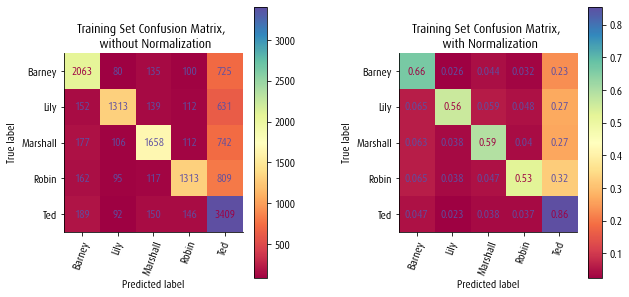

Cohen's Kappa Score for Training Set:
0.566
Matthew's Correlation Coefficient for Training Set:
0.578
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.28      0.31      1529
        Lily       0.32      0.20      0.25      1156
    Marshall       0.30      0.23      0.26      1377
       Robin       0.26      0.18      0.21      1229
         Ted       0.33      0.56      0.42      1963

    accuracy                           0.32      7254
   macro avg       0.31      0.29      0.29      7254
weighted avg       0.31      0.32      0.30      7254



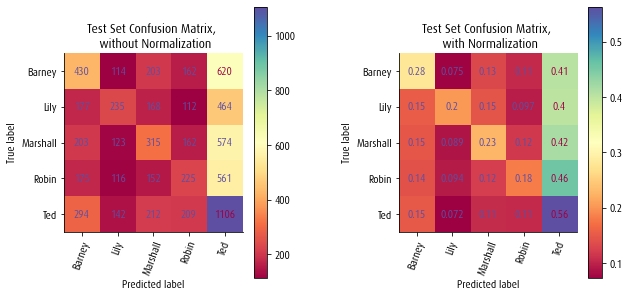

Cohen's Kappa Score for Test Set:
0.121
Matthew's Correlation Coefficient for Test Set:
0.124


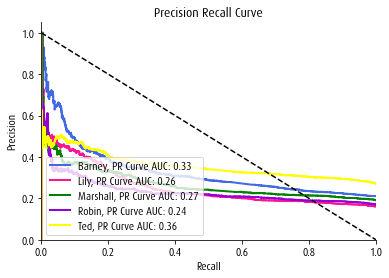

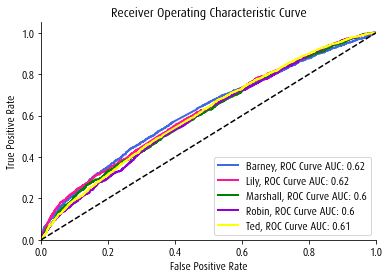

Model Name                           LogRegCV
Accuracy Score                       0.318583
Precision Score                      0.309874
Recall Score                         0.291955
F1 Score                             0.289549
Cohen's Kappa Score                     0.121
Matthew's Correlation Coefficient       0.124
dtype: object

In [11]:
Report = fitmodel(LRpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'LogRegCV')
scoretable.loc['1'] = Report
Report

The accuracy for the test set is 32%, while it is 66% for the training set; this difference tells us that the model is overfit on the training data. An accuracy of 66% is better than random guessing. It makes sense that recall for Ted is the highest, as Ted has the most lines.

First one is done! And our graphs are looking pretty good, let's hustle.

### Logistic Regression using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.65      0.63      0.64      3103
        Lily       0.72      0.44      0.55      2347
    Marshall       0.67      0.52      0.58      2795
       Robin       0.68      0.43      0.52      2496
         Ted       0.50      0.83      0.62      3986

    accuracy                           0.60     14727
   macro avg       0.64      0.57      0.58     14727
weighted avg       0.63      0.60      0.59     14727



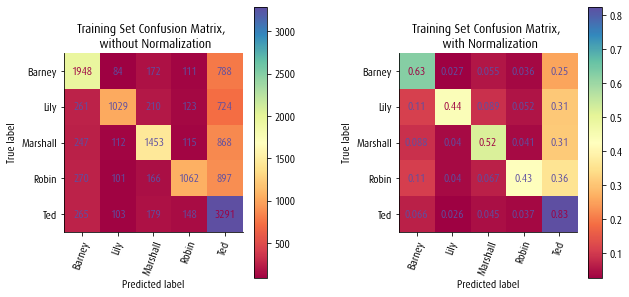

Cohen's Kappa Score for Training Set:
0.479
Matthew's Correlation Coefficient for Training Set:
0.493
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.30      0.32      1529
        Lily       0.33      0.17      0.22      1156
    Marshall       0.30      0.22      0.25      1377
       Robin       0.26      0.15      0.19      1229
         Ted       0.32      0.60      0.42      1963

    accuracy                           0.32      7254
   macro avg       0.31      0.29      0.28      7254
weighted avg       0.31      0.32      0.30      7254



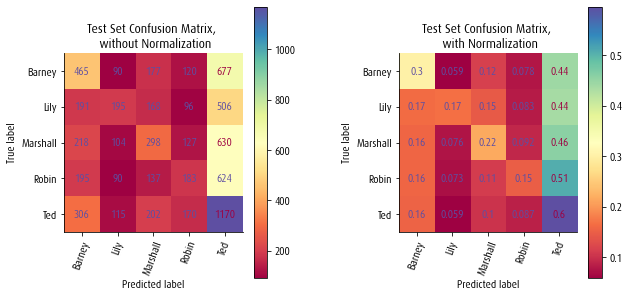

Cohen's Kappa Score for Test Set:
0.116
Matthew's Correlation Coefficient for Test Set:
0.121


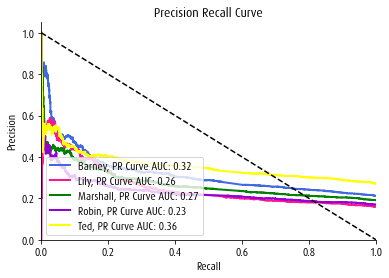

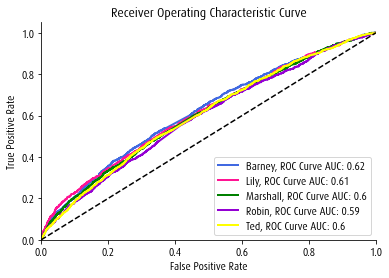

Model Name                           LogRegTF
Accuracy Score                       0.318583
Precision Score                      0.311445
Recall Score                         0.286829
F1 Score                             0.281198
Cohen's Kappa Score                     0.116
Matthew's Correlation Coefficient       0.121
dtype: object

In [12]:
LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression()), 
]) #Creating Logistic Regression pipeline with tfidf vectorizer

Report = fitmodel(LRpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'LogRegTF')
scoretable.loc['2'] = Report
Report

There's been a slight change in curve scores, but the classification report returned the same scores. Let's move to the next model.

## Multinomial Naive Bayes

Here we'll be doing the same thing as above. We will build out two models, one with each vectorizer, and add the scores to our baseline scores dataframe.

### Multinomial Naive Bayes using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.64      0.57      0.60      3103
        Lily       0.79      0.37      0.50      2347
    Marshall       0.70      0.47      0.56      2795
       Robin       0.75      0.36      0.48      2496
         Ted       0.44      0.87      0.59      3986

    accuracy                           0.56     14727
   macro avg       0.66      0.53      0.55     14727
weighted avg       0.64      0.56      0.55     14727



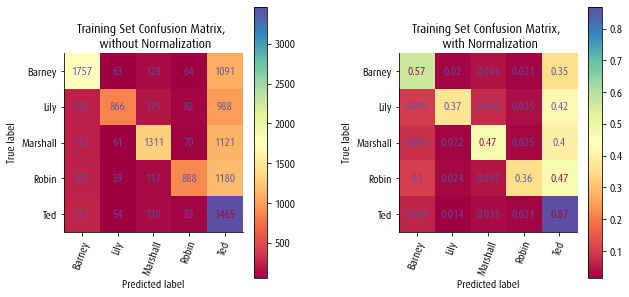

Cohen's Kappa Score for Training Set:
0.43
Matthew's Correlation Coefficient for Training Set:
0.458
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.29      0.31      1529
        Lily       0.37      0.12      0.19      1156
    Marshall       0.31      0.20      0.24      1377
       Robin       0.30      0.12      0.17      1229
         Ted       0.31      0.68      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.28      0.27      7254
weighted avg       0.33      0.32      0.29      7254



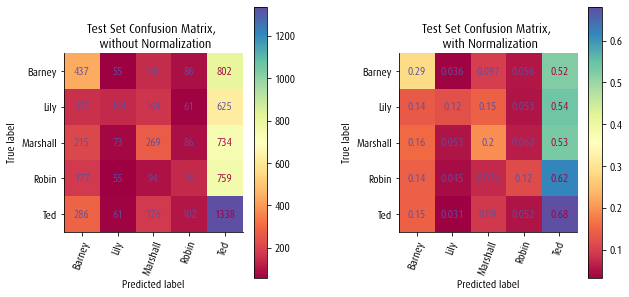

Cohen's Kappa Score for Test Set:
0.11
Matthew's Correlation Coefficient for Test Set:
0.121


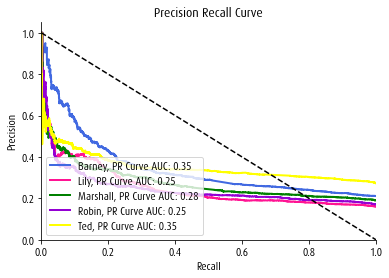

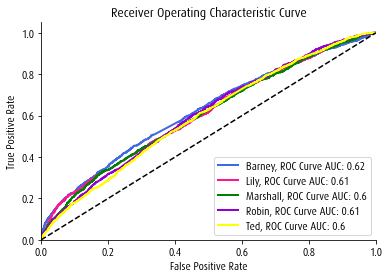

Model Name                              MNBCV
Accuracy Score                       0.321478
Precision Score                      0.328686
Recall Score                         0.280901
F1 Score                             0.267632
Cohen's Kappa Score                      0.11
Matthew's Correlation Coefficient       0.121
dtype: object

In [13]:
MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB()), 
]) #Creating multinomial naive bayes pipeline with count vectorizer

Report = fitmodel(MNBpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'MNBCV')
scoretable.loc['3'] = Report
Report

### Multinomial Bayes using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.70      0.51      0.59      3103
        Lily       0.86      0.24      0.37      2347
    Marshall       0.77      0.35      0.48      2795
       Robin       0.87      0.23      0.36      2496
         Ted       0.38      0.95      0.55      3986

    accuracy                           0.51     14727
   macro avg       0.72      0.46      0.47     14727
weighted avg       0.68      0.51      0.49     14727



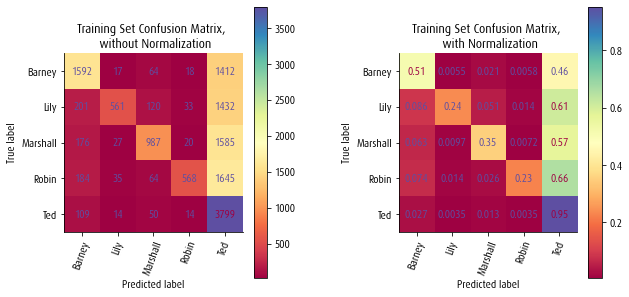

Cohen's Kappa Score for Training Set:
0.351
Matthew's Correlation Coefficient for Training Set:
0.414
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.35      0.21      0.26      1529
        Lily       0.43      0.07      0.12      1156
    Marshall       0.34      0.12      0.18      1377
       Robin       0.36      0.06      0.10      1229
         Ted       0.30      0.82      0.44      1963

    accuracy                           0.31      7254
   macro avg       0.35      0.26      0.22      7254
weighted avg       0.35      0.31      0.24      7254



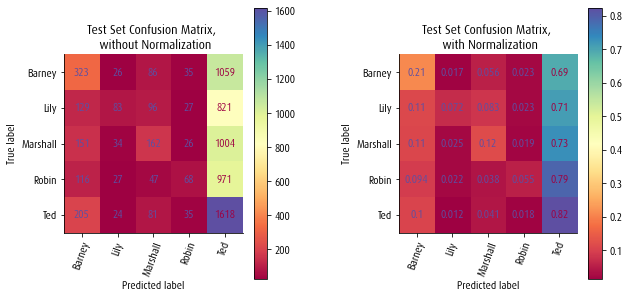

Cohen's Kappa Score for Test Set:
0.078
Matthew's Correlation Coefficient for Test Set:
0.103


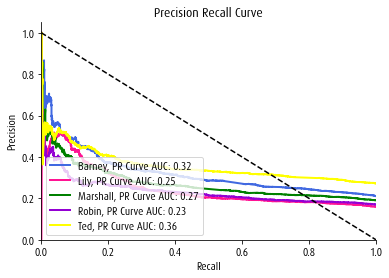

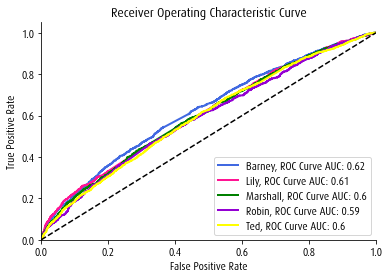

Model Name                              MNBTF
Accuracy Score                       0.310725
Precision Score                      0.354455
Recall Score                         0.256055
F1 Score                               0.2185
Cohen's Kappa Score                     0.078
Matthew's Correlation Coefficient       0.103
dtype: object

In [14]:
MNBpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB()), 
]) #Creating multinomial naive bayes pipeline with tfidf vectorizer

Report = fitmodel(MNBpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'MNBTF')
scoretable.loc['4'] = Report
Report

Everything is looking good so far. I'm going to zoom through the rest of these now.

## K Nearest Neighbors

### K Nearest Neighbors using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.45      0.56      0.50      3103
        Lily       0.45      0.39      0.42      2347
    Marshall       0.41      0.46      0.44      2795
       Robin       0.43      0.42      0.42      2496
         Ted       0.53      0.44      0.48      3986

    accuracy                           0.46     14727
   macro avg       0.46      0.45      0.45     14727
weighted avg       0.46      0.46      0.46     14727



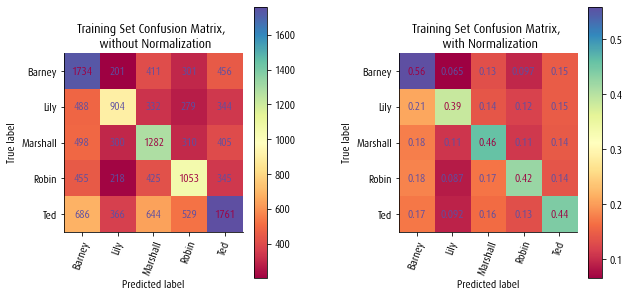

Cohen's Kappa Score for Training Set:
0.316
Matthew's Correlation Coefficient for Training Set:
0.318
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.23      0.26      0.24      1529
        Lily       0.21      0.18      0.19      1156
    Marshall       0.21      0.24      0.23      1377
       Robin       0.19      0.21      0.20      1229
         Ted       0.31      0.26      0.28      1963

    accuracy                           0.23      7254
   macro avg       0.23      0.23      0.23      7254
weighted avg       0.24      0.23      0.23      7254



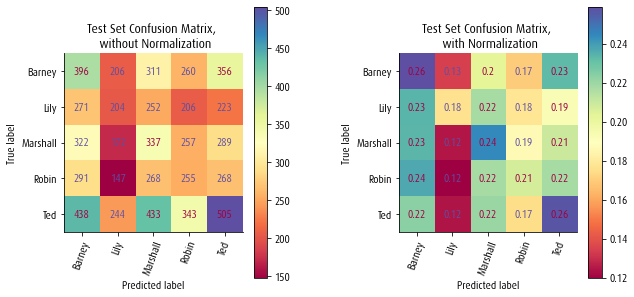

Cohen's Kappa Score for Test Set:
0.036
Matthew's Correlation Coefficient for Test Set:
0.036


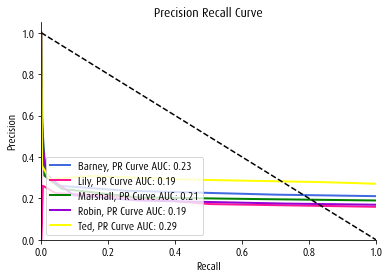

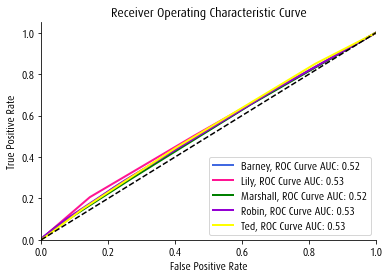

Model Name                              KNNCV
Accuracy Score                        0.23394
Precision Score                      0.230286
Recall Score                         0.228989
F1 Score                             0.228425
Cohen's Kappa Score                     0.036
Matthew's Correlation Coefficient       0.036
dtype: object

In [15]:
KNNpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', KNeighborsClassifier()), 
]) #Creating k nearest neighbors pipeline with count vectorizer

Report = fitmodel(KNNpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'KNNCV')
scoretable.loc['5'] = Report
Report

### K Nearest Neighbors using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.48      0.53      0.50      3103
        Lily       0.47      0.43      0.45      2347
    Marshall       0.46      0.45      0.46      2795
       Robin       0.44      0.38      0.41      2496
         Ted       0.47      0.51      0.49      3986

    accuracy                           0.47     14727
   macro avg       0.47      0.46      0.46     14727
weighted avg       0.47      0.47      0.47     14727



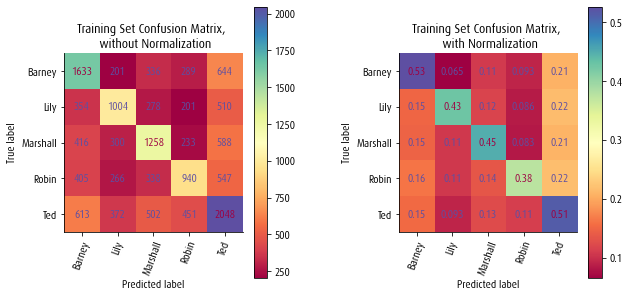

Cohen's Kappa Score for Training Set:
0.325
Matthew's Correlation Coefficient for Training Set:
0.325
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.25      0.26      0.25      1529
        Lily       0.18      0.16      0.17      1156
    Marshall       0.22      0.20      0.21      1377
       Robin       0.16      0.14      0.15      1229
         Ted       0.30      0.35      0.32      1963

    accuracy                           0.24      7254
   macro avg       0.22      0.22      0.22      7254
weighted avg       0.23      0.24      0.23      7254



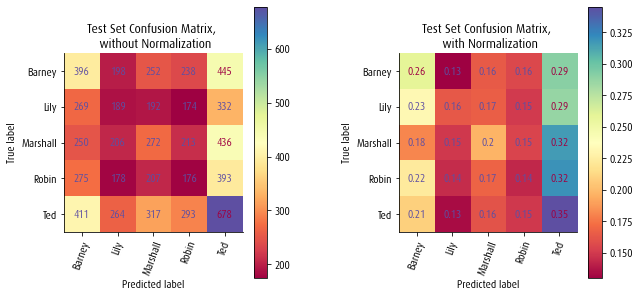

Cohen's Kappa Score for Test Set:
0.03
Matthew's Correlation Coefficient for Test Set:
0.03


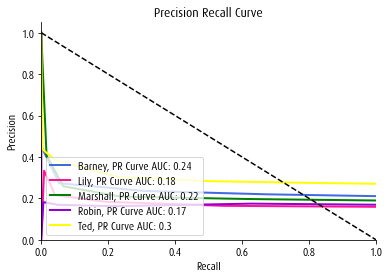

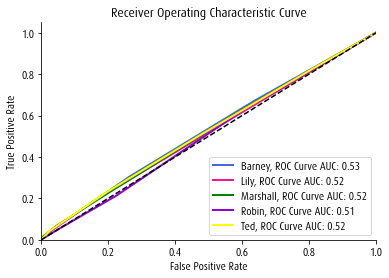

Model Name                              KNNTF
Accuracy Score                        0.23587
Precision Score                      0.221407
Recall Score                         0.221723
F1 Score                             0.220849
Cohen's Kappa Score                      0.03
Matthew's Correlation Coefficient        0.03
dtype: object

In [16]:
KNNpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', KNeighborsClassifier()), 
]) #Creating k nearest neighbors pipeline with tfidf vectorizer

Report = fitmodel(KNNpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'KNNTF')
scoretable.loc['6'] = Report
Report

## Random Forest

### Random Forest using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.89      0.91      3103
        Lily       0.94      0.86      0.90      2347
    Marshall       0.96      0.85      0.90      2795
       Robin       0.93      0.85      0.89      2496
         Ted       0.78      0.95      0.86      3986

    accuracy                           0.89     14727
   macro avg       0.91      0.88      0.89     14727
weighted avg       0.90      0.89      0.89     14727



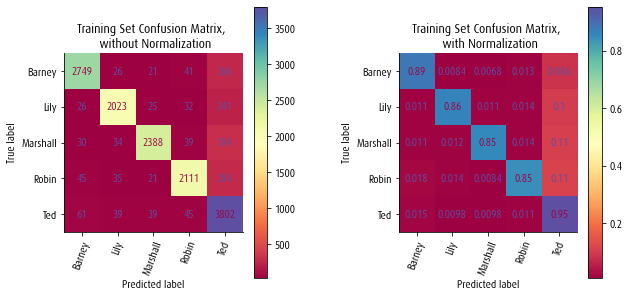

Cohen's Kappa Score for Training Set:
0.857
Matthew's Correlation Coefficient for Training Set:
0.86
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.31      0.27      0.29      1529
        Lily       0.27      0.23      0.25      1156
    Marshall       0.28      0.22      0.25      1377
       Robin       0.26      0.19      0.22      1229
         Ted       0.32      0.48      0.38      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.28      0.28      7254
weighted avg       0.29      0.30      0.29      7254



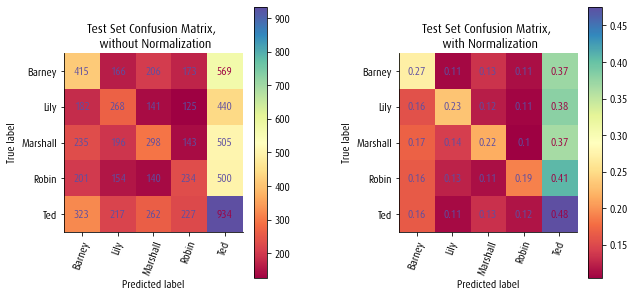

Cohen's Kappa Score for Test Set:
0.098
Matthew's Correlation Coefficient for Test Set:
0.1


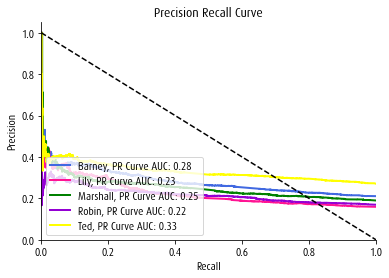

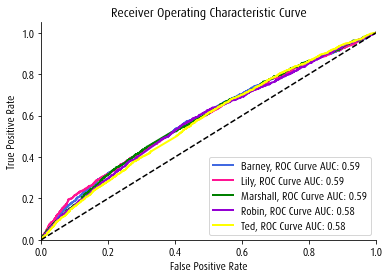

Model Name                               RFCV
Accuracy Score                        0.29625
Precision Score                       0.28693
Recall Score                         0.277173
F1 Score                              0.27641
Cohen's Kappa Score                     0.098
Matthew's Correlation Coefficient         0.1
dtype: object

In [17]:
RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier()), 
]) #Creating random forest pipeline with count vectorizer

Report = fitmodel(RFpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'RFCV')
scoretable.loc['7'] = Report
Report

### Random Forest using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.95      0.88      0.91      3103
        Lily       0.93      0.86      0.89      2347
    Marshall       0.96      0.85      0.90      2795
       Robin       0.93      0.84      0.88      2496
         Ted       0.77      0.95      0.85      3986

    accuracy                           0.89     14727
   macro avg       0.91      0.88      0.89     14727
weighted avg       0.90      0.89      0.89     14727



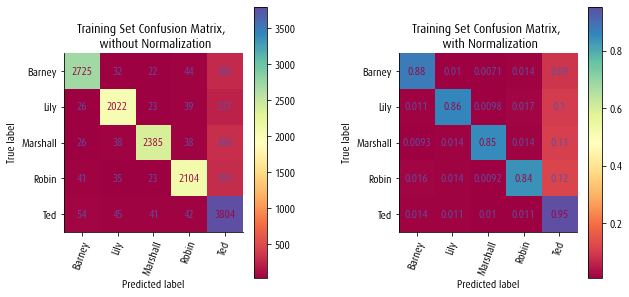

Cohen's Kappa Score for Training Set:
0.854
Matthew's Correlation Coefficient for Training Set:
0.857
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.30      0.31      1529
        Lily       0.26      0.18      0.21      1156
    Marshall       0.29      0.20      0.23      1377
       Robin       0.26      0.16      0.20      1229
         Ted       0.31      0.53      0.39      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.27      0.27      7254
weighted avg       0.29      0.30      0.28      7254



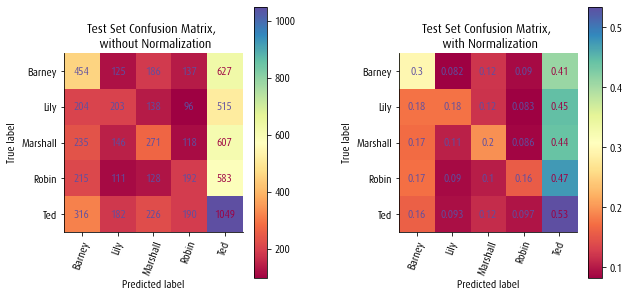

Cohen's Kappa Score for Test Set:
0.094
Matthew's Correlation Coefficient for Test Set:
0.097


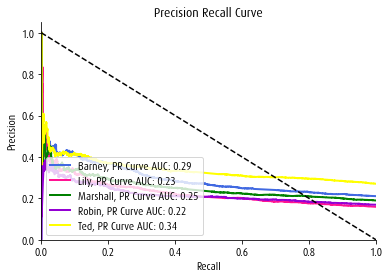

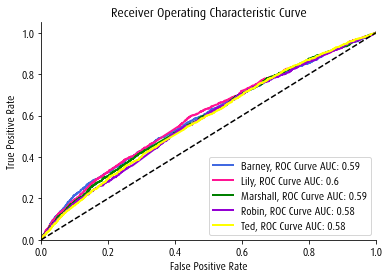

Model Name                               RFTF
Accuracy Score                       0.299007
Precision Score                       0.28825
Recall Score                         0.271989
F1 Score                             0.267988
Cohen's Kappa Score                     0.094
Matthew's Correlation Coefficient       0.097
dtype: object

In [18]:
RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier()), 
]) #Creating random forest pipeline with tfidf vectorizer

Report = fitmodel(RFpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'RFTF')
scoretable.loc['8'] = Report
Report

## Decision Tree

### Decision Tree using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.91      0.91      0.91      3103
        Lily       0.92      0.88      0.90      2347
    Marshall       0.96      0.86      0.90      2795
       Robin       0.94      0.84      0.89      2496
         Ted       0.79      0.93      0.86      3986

    accuracy                           0.89     14727
   macro avg       0.90      0.88      0.89     14727
weighted avg       0.89      0.89      0.89     14727



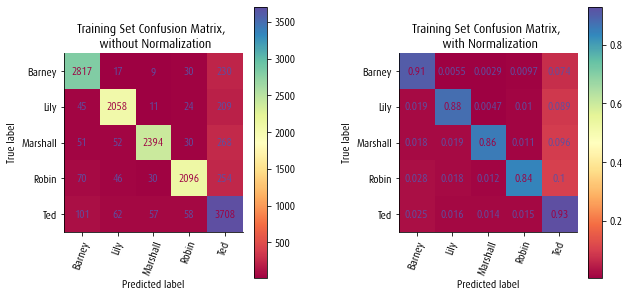

Cohen's Kappa Score for Training Set:
0.857
Matthew's Correlation Coefficient for Training Set:
0.859
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.28      0.27      0.28      1529
        Lily       0.25      0.26      0.25      1156
    Marshall       0.27      0.20      0.23      1377
       Robin       0.23      0.19      0.21      1229
         Ted       0.32      0.42      0.36      1963

    accuracy                           0.28      7254
   macro avg       0.27      0.27      0.27      7254
weighted avg       0.28      0.28      0.28      7254



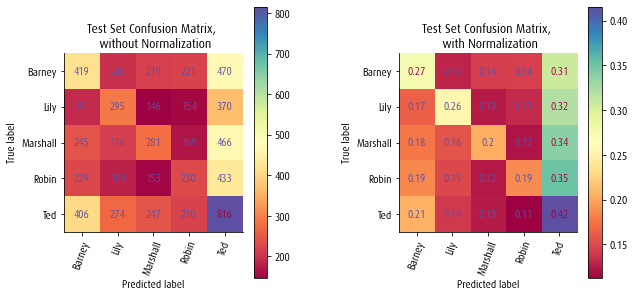

Cohen's Kappa Score for Test Set:
0.085
Matthew's Correlation Coefficient for Test Set:
0.085


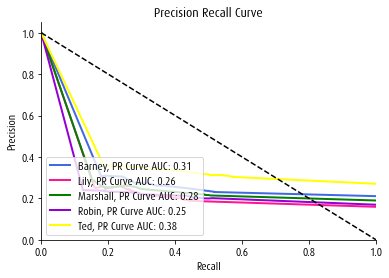

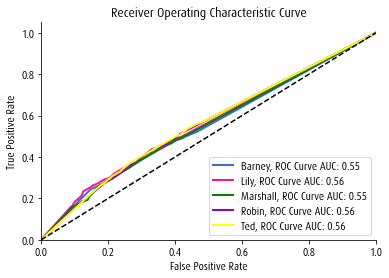

Model Name                               DTCV
Accuracy Score                       0.281362
Precision Score                      0.270593
Recall Score                         0.267225
F1 Score                             0.266286
Cohen's Kappa Score                     0.085
Matthew's Correlation Coefficient       0.085
dtype: object

In [19]:
DTpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', DecisionTreeClassifier()), 
]) #Creating decision tree pipeline with count vectorizer

Report = fitmodel(DTpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'DTCV')
scoretable.loc['9'] = Report
Report

### Decision Tree using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.92      0.90      0.91      3103
        Lily       0.92      0.88      0.90      2347
    Marshall       0.96      0.85      0.90      2795
       Robin       0.93      0.84      0.88      2496
         Ted       0.79      0.93      0.85      3986

    accuracy                           0.89     14727
   macro avg       0.90      0.88      0.89     14727
weighted avg       0.89      0.89      0.89     14727



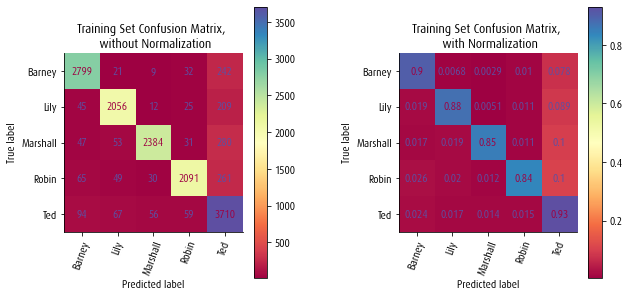

Cohen's Kappa Score for Training Set:
0.855
Matthew's Correlation Coefficient for Training Set:
0.856
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.30      0.28      0.29      1529
        Lily       0.23      0.20      0.22      1156
    Marshall       0.26      0.21      0.23      1377
       Robin       0.23      0.17      0.19      1229
         Ted       0.32      0.45      0.38      1963

    accuracy                           0.28      7254
   macro avg       0.27      0.26      0.26      7254
weighted avg       0.27      0.28      0.27      7254



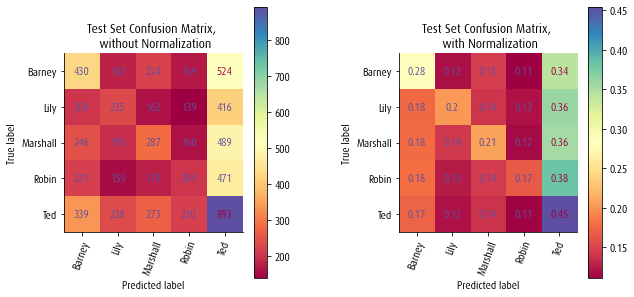

Cohen's Kappa Score for Test Set:
0.082
Matthew's Correlation Coefficient for Test Set:
0.083


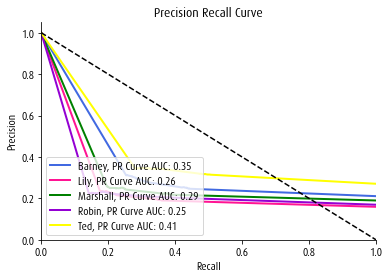

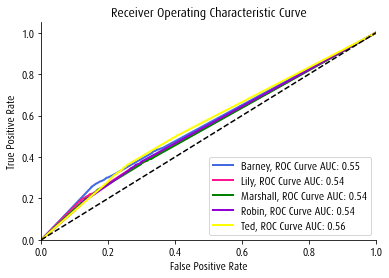

Model Name                               DTTF
Accuracy Score                       0.282465
Precision Score                      0.267241
Recall Score                         0.262769
F1 Score                              0.26091
Cohen's Kappa Score                     0.082
Matthew's Correlation Coefficient       0.083
dtype: object

In [20]:
DTpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', DecisionTreeClassifier()), 
]) #Creating decision tree pipeline with tfidf vectorizer

Report = fitmodel(DTpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'DTTF')
scoretable.loc['10'] = Report
Report

## AdaBoost

### AdaBoost using Count Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.42      0.12      0.18      3103
        Lily       0.54      0.05      0.10      2347
    Marshall       0.41      0.13      0.19      2795
       Robin       0.45      0.04      0.08      2496
         Ted       0.29      0.91      0.44      3986

    accuracy                           0.31     14727
   macro avg       0.42      0.25      0.20     14727
weighted avg       0.41      0.31      0.22     14727



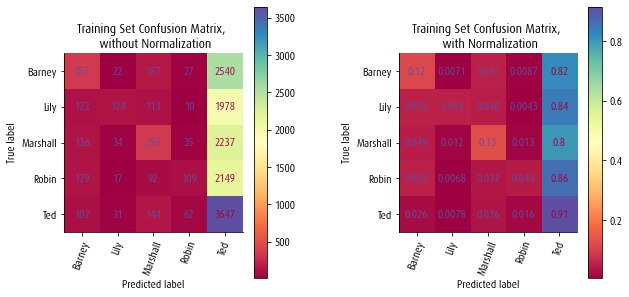

Cohen's Kappa Score for Training Set:
0.071
Matthew's Correlation Coefficient for Training Set:
0.114
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.39      0.10      0.16      1529
        Lily       0.47      0.04      0.08      1156
    Marshall       0.39      0.11      0.17      1377
       Robin       0.42      0.04      0.07      1229
         Ted       0.29      0.92      0.44      1963

    accuracy                           0.30      7254
   macro avg       0.39      0.24      0.18      7254
weighted avg       0.38      0.30      0.21      7254



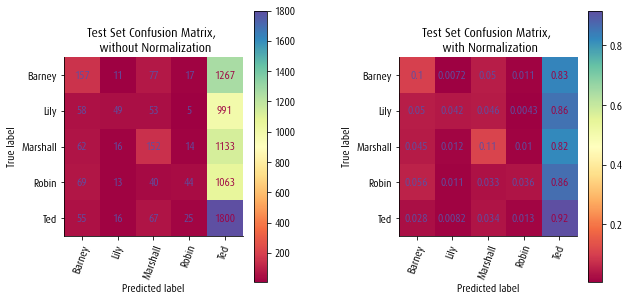

Cohen's Kappa Score for Test Set:
0.059
Matthew's Correlation Coefficient for Test Set:
0.098


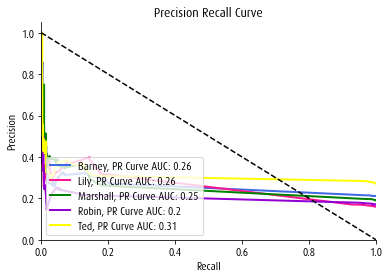

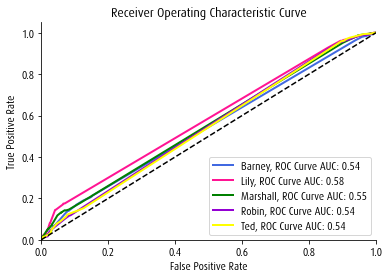

Model Name                               ABCV
Accuracy Score                       0.303557
Precision Score                      0.391159
Recall Score                         0.241644
F1 Score                             0.183327
Cohen's Kappa Score                     0.059
Matthew's Correlation Coefficient       0.098
dtype: object

In [21]:
ABpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', AdaBoostClassifier()), 
]) #Creating adaboost pipeline with count vectorizer

Report = fitmodel(ABpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'ABCV')
scoretable.loc['11'] = Report
Report

### AdaBoost using TF-IDF Vectorizer

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.40      0.13      0.19      3103
        Lily       0.47      0.14      0.21      2347
    Marshall       0.42      0.10      0.16      2795
       Robin       0.48      0.04      0.08      2496
         Ted       0.29      0.89      0.44      3986

    accuracy                           0.31     14727
   macro avg       0.41      0.26      0.22     14727
weighted avg       0.40      0.31      0.24     14727



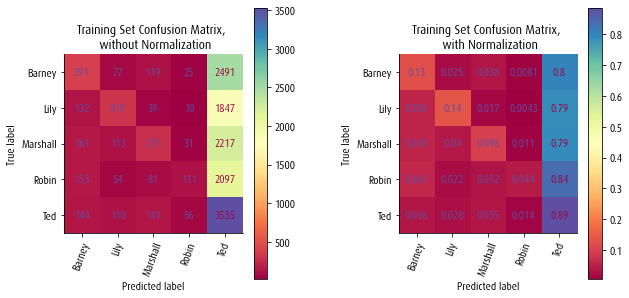

Cohen's Kappa Score for Training Set:
0.078
Matthew's Correlation Coefficient for Training Set:
0.118
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.38      0.12      0.18      1529
        Lily       0.39      0.11      0.17      1156
    Marshall       0.42      0.10      0.16      1377
       Robin       0.40      0.03      0.06      1229
         Ted       0.29      0.88      0.43      1963

    accuracy                           0.31      7254
   macro avg       0.38      0.25      0.20      7254
weighted avg       0.37      0.31      0.22      7254



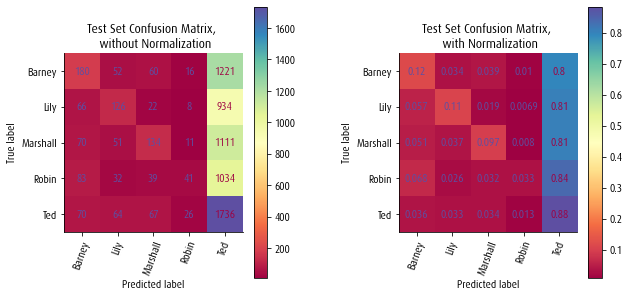

Cohen's Kappa Score for Test Set:
0.066
Matthew's Correlation Coefficient for Test Set:
0.1


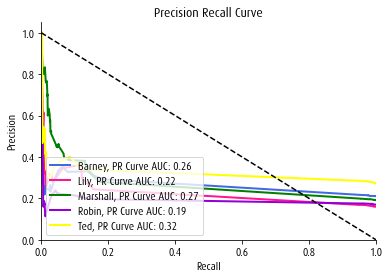

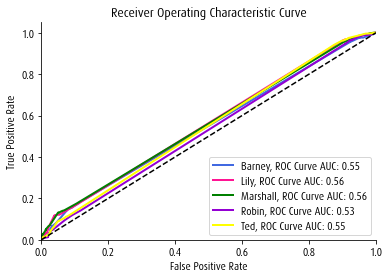

Model Name                               ABTF
Accuracy Score                       0.305624
Precision Score                      0.375441
Recall Score                         0.248351
F1 Score                             0.200747
Cohen's Kappa Score                     0.066
Matthew's Correlation Coefficient         0.1
dtype: object

In [22]:
ABpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', AdaBoostClassifier()), 
]) #Creating adaboost pipeline with tfidf vectorizer

Report = fitmodel(ABpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'ABTF')
scoretable.loc['12'] = Report
Report

We've finished our baseline models! Let's compare them.

# Comparing Baseline Models

We're going to look at our final baseline model scores table we created throughout this notebook and sort it by Cohen's Kappa Score. While we could look at accuracy, this dataset is imbalanced because some characters have more lines than others, and that's not something we can balance out. Cohen's Kappa score evaluates multi-class classifiers on imbalanced datasets. We're looking for a score close to 1; the closer a score is to 1, the better the classifier is.

In [23]:
scoretable.sort_values(by = ["Cohen's Kappa Score"], ascending = False) #Comparing baseline models

Model Name Accuracy Score Precision Score Recall Score  F1 Score  \
1    LogRegCV       0.318583        0.309874     0.291955  0.289549   
2    LogRegTF       0.318583        0.311445     0.286829  0.281198   
3       MNBCV       0.321478        0.328686     0.280901  0.267632   
7        RFCV        0.29625         0.28693     0.277173   0.27641   
8        RFTF       0.299007         0.28825     0.271989  0.267988   
9        DTCV       0.281362        0.270593     0.267225  0.266286   
10       DTTF       0.282465        0.267241     0.262769   0.26091   
4       MNBTF       0.310725        0.354455     0.256055    0.2185   
12       ABTF       0.305624        0.375441     0.248351  0.200747   
11       ABCV       0.303557        0.391159     0.241644  0.183327   
5       KNNCV        0.23394        0.230286     0.228989  0.228425   
6       KNNTF        0.23587        0.221407     0.221723  0.220849   
13        NaN            NaN             NaN          NaN       NaN   
14        NaN            NaN             NaN          NaN       NaN   
15        NaN            NaN             NaN          NaN       NaN   
16        NaN            NaN             NaN          NaN       NaN   
17        NaN            NaN             NaN          NaN       NaN   
18        NaN            NaN             NaN          NaN       NaN   
19        NaN            NaN             NaN          NaN       NaN   
20        NaN            NaN             NaN          NaN       NaN   
21        NaN            NaN             NaN          NaN       NaN   
22        NaN            NaN             NaN          NaN       NaN   
23        NaN            NaN             NaN          NaN       NaN   
24        NaN            NaN             NaN          NaN       NaN   
25        NaN            NaN             NaN          NaN       NaN   
26        NaN            NaN             NaN          NaN       NaN   
27        NaN            NaN             NaN          NaN       NaN   
28        NaN            NaN             NaN          NaN       NaN   
29        NaN            NaN             NaN          NaN       NaN   
30        NaN            NaN             NaN          NaN       NaN   
31        NaN            NaN             NaN          NaN       NaN   
32        NaN            NaN             NaN          NaN       NaN   
33        NaN            NaN             NaN          NaN       NaN   
34        NaN            NaN             NaN          NaN       NaN   
35        NaN            NaN             NaN          NaN       NaN   

   Cohen's Kappa Score Matthew's Correlation Coefficient  
1                0.121                             0.124  
2                0.116                             0.121  
3                 0.11                             0.121  
7                0.098                               0.1  
8                0.094                             0.097  
9                0.085                             0.085  
10               0.082                             0.083  
4                0.078                             0.103  
12               0.066                               0.1  
11               0.059                             0.098  
5                0.036                             0.036  
6                 0.03                              0.03  
13                 NaN                               NaN  
14                 NaN                               NaN  
15                 NaN                               NaN  
16                 NaN                               NaN  
17                 NaN                               NaN  
18                 NaN                               NaN  
19                 NaN                               NaN  
20                 NaN                               NaN  
21                 NaN                               NaN  
22                 NaN                               NaN  
23                 NaN                               NaN  
24                 NaN        

While the Cohen's Kappa scores vary, the accuracy scores are also very close. In general, the models were overfitting to the training set and we're really seeing that with the precision recall curves; most of them are not good classifiers.

The top five baseline models are:

* Logistic Regression using Count Vectorizer: Cohen's Kappa = 0.121; Accuracy = 0.32
* Logistic Regression using TF-IDF Vectorizer: Cohen's Kappa = 0.116; Accuracy = 0.32
* Multinomial Naive Bayes using Count Vectorizer: Cohen's Kappa = 0.110; Accuracy = 0.32
* Random Forest using Count Vectorizer: Cohen's Kappa = 0.098; Accuracy = 0.30
* Random Forest using TF-IDF Vectorizer: Cohen's Kappa = 0.094; Accuracy = 0.28

It's worth noting that while these have the highest Cohen's Kappa scores out of all the baseline models, we would normally want these numbers to be closer to 1. We will tune these models though and hopefully raise these numbers.

# Tuning Models

For each logistic regression model, I'm going to set the class weight equal to balanced. I'm also going to try different values for C (0.5 and 1e50), then let's try these new values of C with class weight equal to balanced. This means each logistic regression/vectorizer combo will have seven tuned models (our subtotal right now is 10 tuned models).

For the multinomial naive bayes model, we'll try three different values for alpha (0.001, 0.01, and 0.1). This means the multinomial naive bayes model will be tuned three times (our subtotal now is 13 tuned models).

For each random forest model, we'll first try setting class weight equal to balanced. Let's also separately try a few different values for the number of estimators (10 and 50), then let's try these new values with class weight equal to balanced. This means each random forest/vectorizer combo will have five tuned models (our total will be 23 tuned models).

## Logistic Regression using Count Vectorizer

We'll be tuning five models:

* Class Weight = Balanced
* C = 0.5
* C = 1e50
* Class Weight = Balanced, C = 0.5
* Class Weight = Balanced, C = 1e50

I'll be doing the same for the Logistic Regression models using the TF-IDF Vectorizer as well.

### Tuned Model 1: Class Weight = Balanced

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.76      0.65      0.70      3103
        Lily       0.62      0.69      0.65      2347
    Marshall       0.67      0.64      0.66      2795
       Robin       0.51      0.71      0.59      2496
         Ted       0.72      0.59      0.65      3986

    accuracy                           0.65     14727
   macro avg       0.66      0.66      0.65     14727
weighted avg       0.67      0.65      0.65     14727



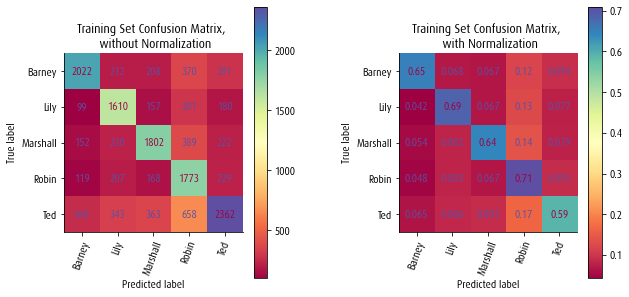

Cohen's Kappa Score for Training Set:
0.561
Matthew's Correlation Coefficient for Training Set:
0.564
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.27      0.30      1529
        Lily       0.26      0.28      0.27      1156
    Marshall       0.28      0.27      0.28      1377
       Robin       0.22      0.35      0.27      1229
         Ted       0.37      0.29      0.33      1963

    accuracy                           0.29      7254
   macro avg       0.30      0.29      0.29      7254
weighted avg       0.31      0.29      0.29      7254



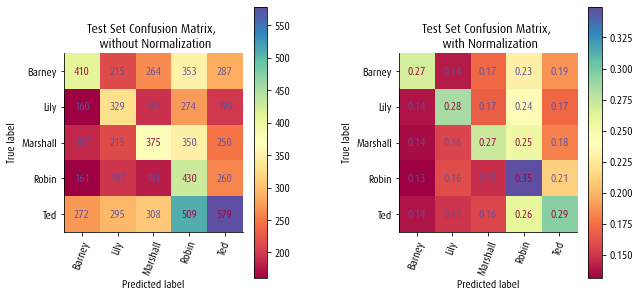

Cohen's Kappa Score for Test Set:
0.116
Matthew's Correlation Coefficient for Test Set:
0.117


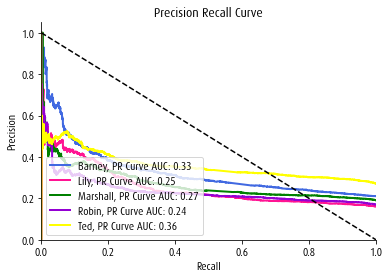

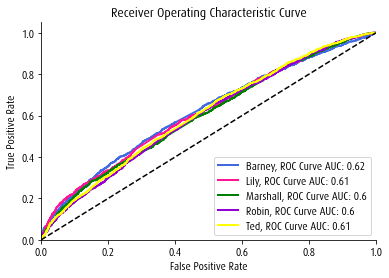

Model Name                             T1LRCV
Accuracy Score                       0.292666
Precision Score                      0.296647
Recall Score                         0.293983
F1 Score                             0.290717
Cohen's Kappa Score                     0.116
Matthew's Correlation Coefficient       0.117
dtype: object

In [24]:
T1LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T1LRpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T1LRCV')
scoretable.loc['13'] = Report
Report

### Tuned Model 2: C = 0.5

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.70      0.62      0.66      3103
        Lily       0.76      0.49      0.59      2347
    Marshall       0.72      0.54      0.62      2795
       Robin       0.71      0.46      0.56      2496
         Ted       0.50      0.85      0.63      3986

    accuracy                           0.62     14727
   macro avg       0.68      0.59      0.61     14727
weighted avg       0.66      0.62      0.62     14727



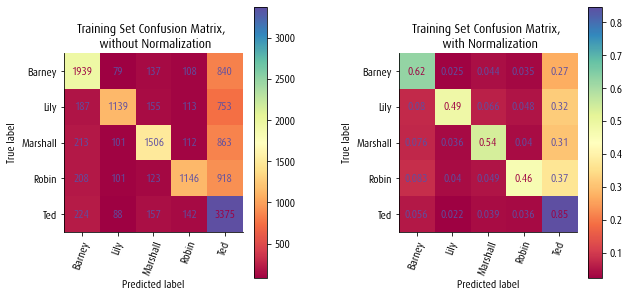

Cohen's Kappa Score for Training Set:
0.507
Matthew's Correlation Coefficient for Training Set:
0.523
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.29      0.31      1529
        Lily       0.34      0.19      0.25      1156
    Marshall       0.31      0.23      0.26      1377
       Robin       0.27      0.17      0.21      1229
         Ted       0.33      0.60      0.42      1963

    accuracy                           0.32      7254
   macro avg       0.32      0.29      0.29      7254
weighted avg       0.32      0.32      0.31      7254



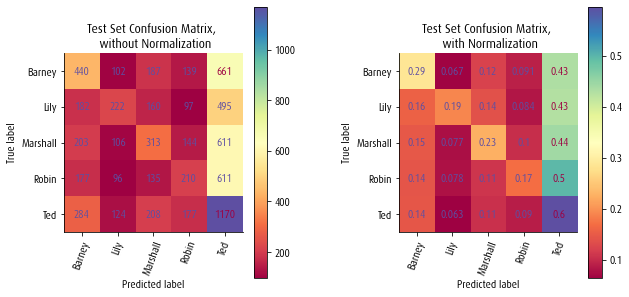

Cohen's Kappa Score for Test Set:
0.125
Matthew's Correlation Coefficient for Test Set:
0.13


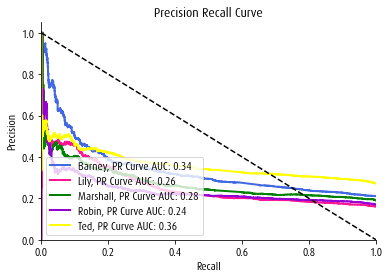

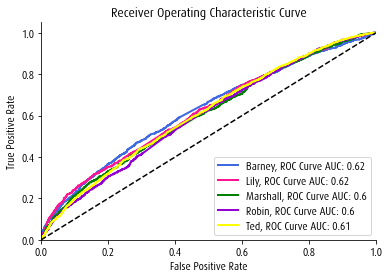

Model Name                             T2LRCV
Accuracy Score                       0.324648
Precision Score                      0.319861
Recall Score                         0.294803
F1 Score                             0.291302
Cohen's Kappa Score                     0.125
Matthew's Correlation Coefficient        0.13
dtype: object

In [25]:
T2LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T2LRpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T2LRCV')
scoretable.loc['14'] = Report
Report

### Tuned Model 3: C = 1e50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.83      0.73      0.77      3103
        Lily       0.80      0.68      0.73      2347
    Marshall       0.78      0.68      0.72      2795
       Robin       0.77      0.64      0.70      2496
         Ted       0.61      0.84      0.71      3986

    accuracy                           0.73     14727
   macro avg       0.76      0.71      0.73     14727
weighted avg       0.75      0.73      0.73     14727



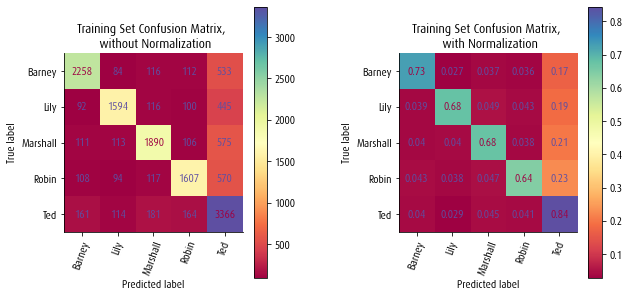

Cohen's Kappa Score for Training Set:
0.652
Matthew's Correlation Coefficient for Training Set:
0.658
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.33      0.28      0.30      1529
        Lily       0.28      0.23      0.25      1156
    Marshall       0.28      0.23      0.26      1377
       Robin       0.23      0.20      0.21      1229
         Ted       0.33      0.48      0.39      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.28      0.28      7254
weighted avg       0.30      0.30      0.29      7254



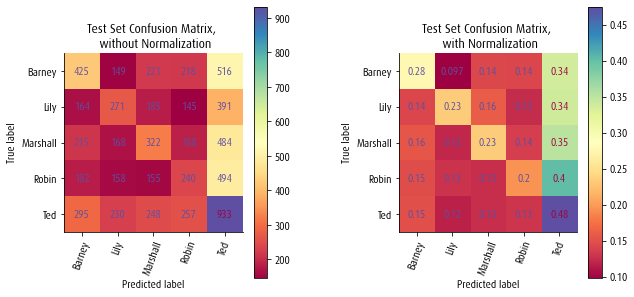

Cohen's Kappa Score for Test Set:
0.108
Matthew's Correlation Coefficient for Test Set:
0.109


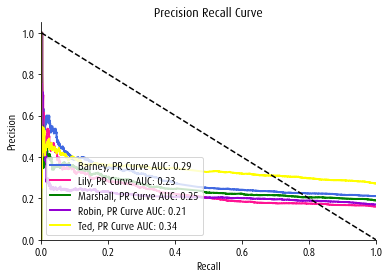

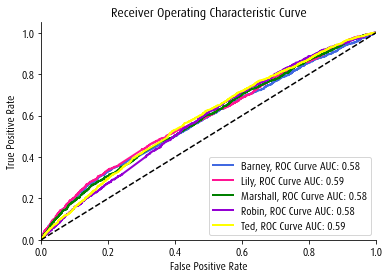

Model Name                             T3LRCV
Accuracy Score                        0.30204
Precision Score                      0.290847
Recall Score                         0.283361
F1 Score                             0.282918
Cohen's Kappa Score                     0.108
Matthew's Correlation Coefficient       0.109
dtype: object

In [26]:
T3LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T3LRpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T3LRCV')
scoretable.loc['15'] = Report
Report

### Tuned Model 4: Class Weight = Balanced; C = 0.5

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.71      0.61      0.66      3103
        Lily       0.58      0.65      0.61      2347
    Marshall       0.63      0.61      0.62      2795
       Robin       0.48      0.67      0.56      2496
         Ted       0.69      0.55      0.61      3986

    accuracy                           0.61     14727
   macro avg       0.62      0.62      0.61     14727
weighted avg       0.63      0.61      0.61     14727



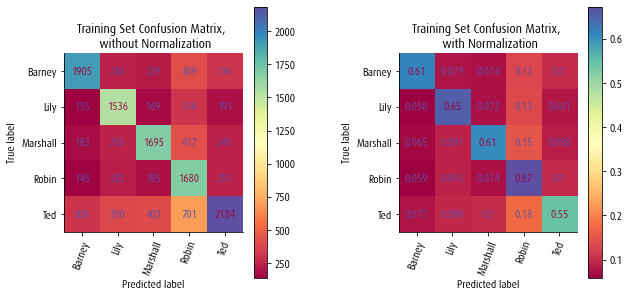

Cohen's Kappa Score for Training Set:
0.513
Matthew's Correlation Coefficient for Training Set:
0.516
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.35      0.28      0.31      1529
        Lily       0.26      0.29      0.27      1156
    Marshall       0.29      0.27      0.28      1377
       Robin       0.23      0.36      0.28      1229
         Ted       0.38      0.29      0.33      1963

    accuracy                           0.30      7254
   macro avg       0.30      0.30      0.29      7254
weighted avg       0.31      0.30      0.30      7254



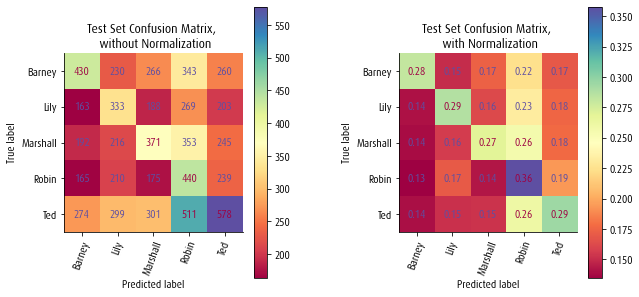

Cohen's Kappa Score for Test Set:
0.121
Matthew's Correlation Coefficient for Test Set:
0.122


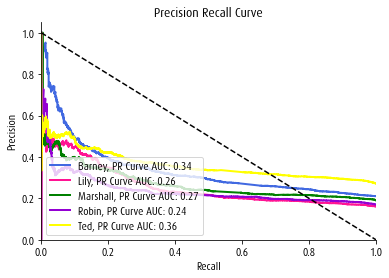

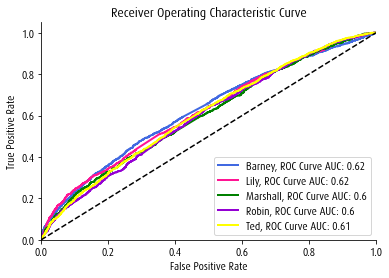

Model Name                             T4LRCV
Accuracy Score                       0.296664
Precision Score                      0.300735
Recall Score                         0.298236
F1 Score                             0.294639
Cohen's Kappa Score                     0.121
Matthew's Correlation Coefficient       0.122
dtype: object

In [27]:
T4LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T4LRpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T4LRCV')
scoretable.loc['16'] = Report
Report

### Tuned Model 5: Class Weight = Balanced; C = 1e50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.81      0.74      0.77      3103
        Lily       0.72      0.72      0.72      2347
    Marshall       0.76      0.69      0.72      2795
       Robin       0.53      0.82      0.65      2496
         Ted       0.81      0.65      0.72      3986

    accuracy                           0.72     14727
   macro avg       0.73      0.72      0.72     14727
weighted avg       0.74      0.72      0.72     14727



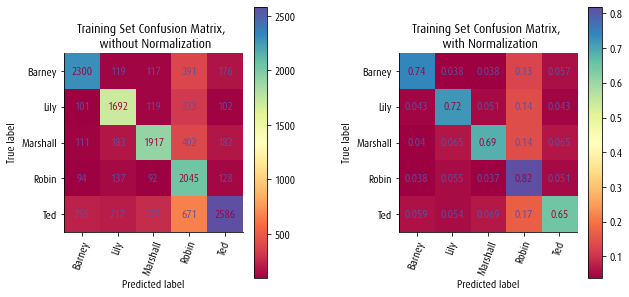

Cohen's Kappa Score for Training Set:
0.644
Matthew's Correlation Coefficient for Training Set:
0.649
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.28      0.30      1529
        Lily       0.26      0.26      0.26      1156
    Marshall       0.28      0.25      0.26      1377
       Robin       0.22      0.36      0.27      1229
         Ted       0.35      0.27      0.30      1963

    accuracy                           0.28      7254
   macro avg       0.28      0.28      0.28      7254
weighted avg       0.29      0.28      0.28      7254



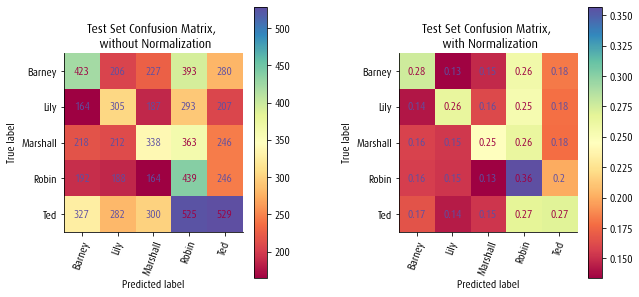

Cohen's Kappa Score for Test Set:
0.101
Matthew's Correlation Coefficient for Test Set:
0.102


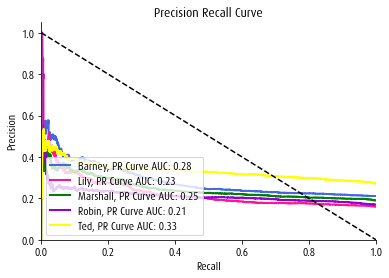

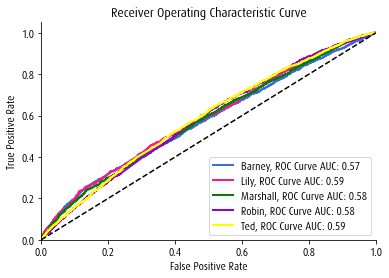

Model Name                             T5LRCV
Accuracy Score                       0.280397
Precision Score                      0.284397
Recall Score                         0.282528
F1 Score                              0.27851
Cohen's Kappa Score                     0.101
Matthew's Correlation Coefficient       0.102
dtype: object

In [28]:
T5LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T5LRpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T5LRCV')
scoretable.loc['17'] = Report
Report

## Logistic Regression using TF-IDF Vectorizer

### Tuning Model 6: Class Weight = Balanced

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.66      0.64      0.65      3103
        Lily       0.58      0.63      0.60      2347
    Marshall       0.61      0.59      0.60      2795
       Robin       0.56      0.60      0.58      2496
         Ted       0.61      0.59      0.60      3986

    accuracy                           0.61     14727
   macro avg       0.61      0.61      0.61     14727
weighted avg       0.61      0.61      0.61     14727



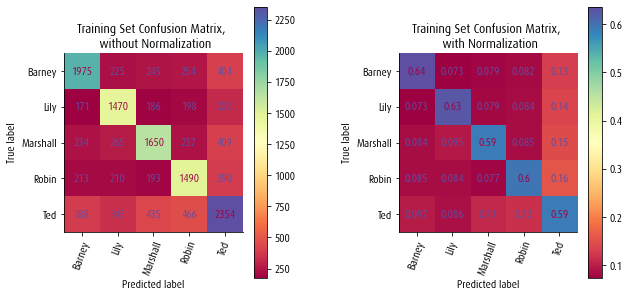

Cohen's Kappa Score for Training Set:
0.505
Matthew's Correlation Coefficient for Training Set:
0.505
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.33      0.30      0.32      1529
        Lily       0.26      0.28      0.27      1156
    Marshall       0.28      0.26      0.27      1377
       Robin       0.25      0.27      0.26      1229
         Ted       0.34      0.35      0.35      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.29      0.29      7254
weighted avg       0.30      0.30      0.30      7254



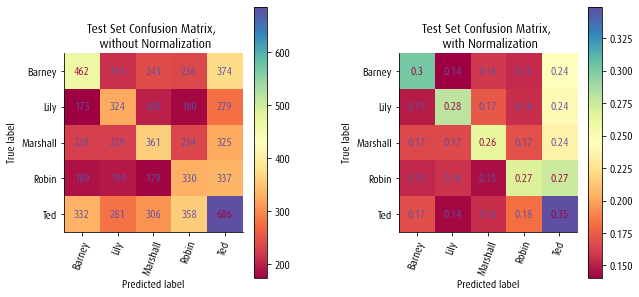

Cohen's Kappa Score for Test Set:
0.115
Matthew's Correlation Coefficient for Test Set:
0.115


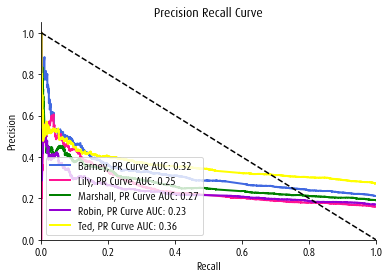

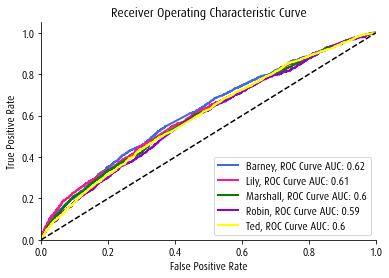

Model Name                             T6LRTF
Accuracy Score                        0.29818
Precision Score                      0.292842
Recall Score                         0.292515
F1 Score                             0.292293
Cohen's Kappa Score                     0.115
Matthew's Correlation Coefficient       0.115
dtype: object

In [29]:
T6LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T6LRpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'T6LRTF')
scoretable.loc['18'] = Report
Report

### Tuned Model 7: C = 0.5

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.60      0.56      0.58      3103
        Lily       0.69      0.30      0.41      2347
    Marshall       0.63      0.43      0.51      2795
       Robin       0.65      0.30      0.41      2496
         Ted       0.44      0.84      0.57      3986

    accuracy                           0.53     14727
   macro avg       0.60      0.49      0.50     14727
weighted avg       0.58      0.53      0.51     14727



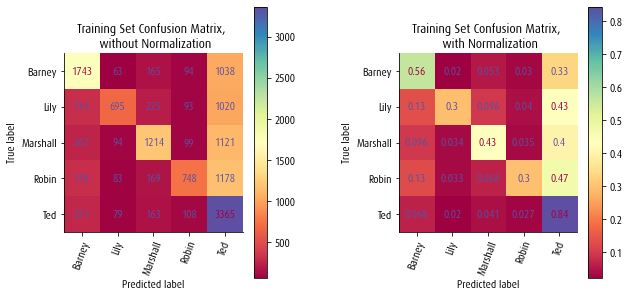

Cohen's Kappa Score for Training Set:
0.384
Matthew's Correlation Coefficient for Training Set:
0.408
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.29      0.31      1529
        Lily       0.36      0.14      0.20      1156
    Marshall       0.30      0.18      0.23      1377
       Robin       0.27      0.11      0.15      1229
         Ted       0.31      0.67      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.32      0.28      0.26      7254
weighted avg       0.32      0.32      0.28      7254



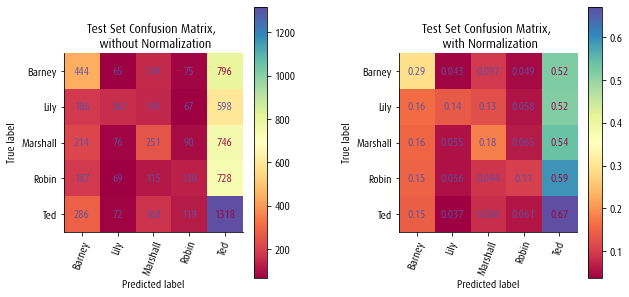

Cohen's Kappa Score for Test Set:
0.105
Matthew's Correlation Coefficient for Test Set:
0.115


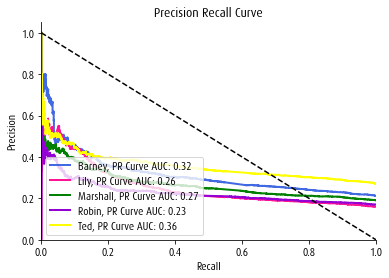

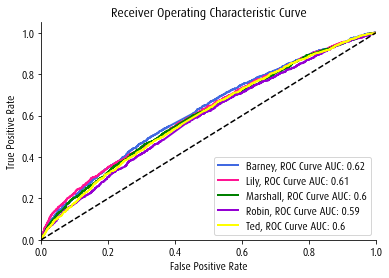

Model Name                             T7LRTF
Accuracy Score                        0.31748
Precision Score                      0.317478
Recall Score                         0.277655
F1 Score                             0.264133
Cohen's Kappa Score                     0.105
Matthew's Correlation Coefficient       0.115
dtype: object

In [30]:
T7LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T7LRpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'T7LRTF')
scoretable.loc['19'] = Report
Report

### Tuned Model 8: C = 1e50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.75      0.71      0.73      3103
        Lily       0.73      0.64      0.68      2347
    Marshall       0.70      0.65      0.68      2795
       Robin       0.70      0.64      0.67      2496
         Ted       0.63      0.76      0.69      3986

    accuracy                           0.69     14727
   macro avg       0.70      0.68      0.69     14727
weighted avg       0.70      0.69      0.69     14727



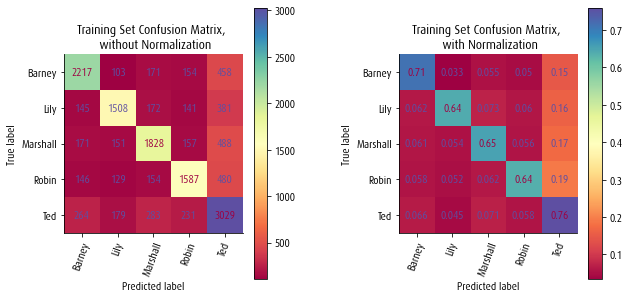

Cohen's Kappa Score for Training Set:
0.607
Matthew's Correlation Coefficient for Training Set:
0.608
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.30      0.31      1529
        Lily       0.26      0.23      0.24      1156
    Marshall       0.28      0.24      0.26      1377
       Robin       0.24      0.22      0.23      1229
         Ted       0.33      0.42      0.37      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.28      0.28      7254
weighted avg       0.29      0.30      0.29      7254



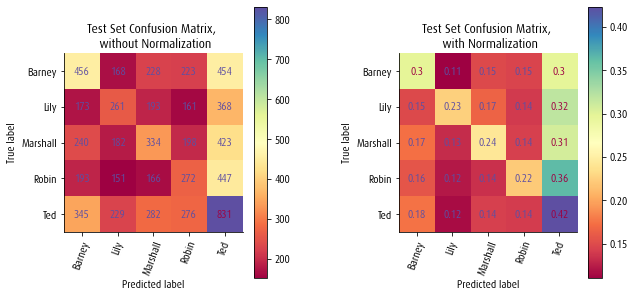

Cohen's Kappa Score for Test Set:
0.105
Matthew's Correlation Coefficient for Test Set:
0.105


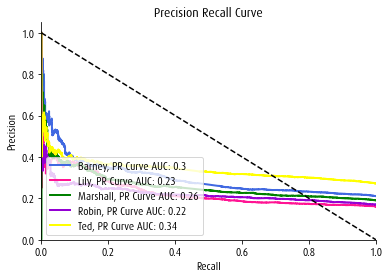

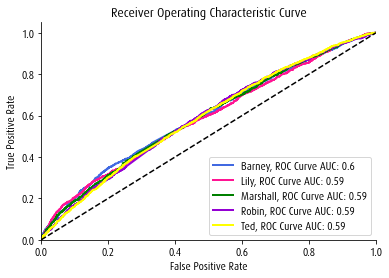

Model Name                             T8LRTF
Accuracy Score                        0.29694
Precision Score                      0.287036
Recall Score                         0.282244
F1 Score                             0.282753
Cohen's Kappa Score                     0.105
Matthew's Correlation Coefficient       0.105
dtype: object

In [31]:
T8LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T8LRpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'T8LRTF')
scoretable.loc['20'] = Report
Report

### Tuned Model 9: Class Weight = Balanced; C = 0.5

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.61      0.59      0.60      3103
        Lily       0.54      0.59      0.56      2347
    Marshall       0.57      0.55      0.56      2795
       Robin       0.53      0.55      0.54      2496
         Ted       0.58      0.55      0.57      3986

    accuracy                           0.57     14727
   macro avg       0.56      0.57      0.57     14727
weighted avg       0.57      0.57      0.57     14727



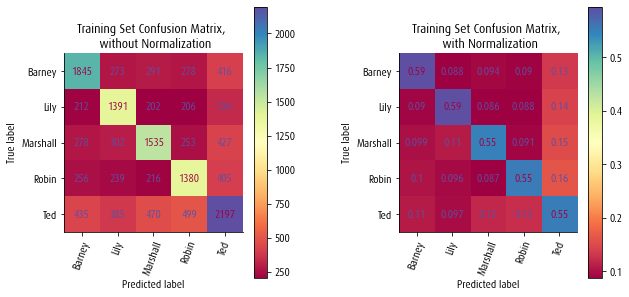

Cohen's Kappa Score for Training Set:
0.455
Matthew's Correlation Coefficient for Training Set:
0.455
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.30      0.31      1529
        Lily       0.26      0.29      0.27      1156
    Marshall       0.28      0.27      0.27      1377
       Robin       0.24      0.26      0.25      1229
         Ted       0.34      0.34      0.34      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.29      0.29      7254
weighted avg       0.30      0.30      0.30      7254



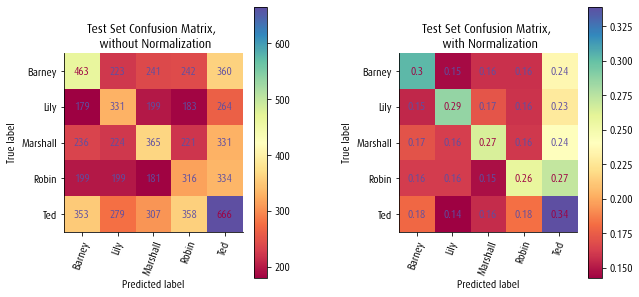

Cohen's Kappa Score for Test Set:
0.111
Matthew's Correlation Coefficient for Test Set:
0.111


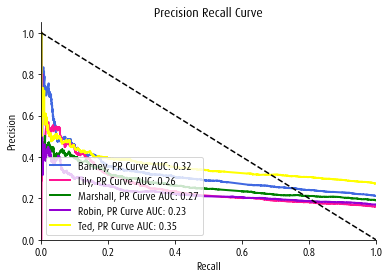

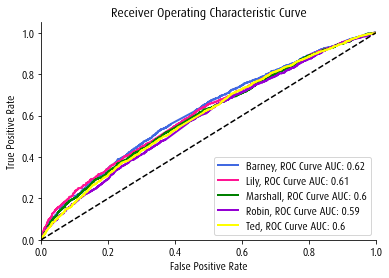

Model Name                             T9LRTF
Accuracy Score                       0.295148
Precision Score                      0.289932
Recall Score                         0.290122
F1 Score                             0.289745
Cohen's Kappa Score                     0.111
Matthew's Correlation Coefficient       0.111
dtype: object

In [32]:
T9LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T9LRpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'T9LRTF')
scoretable.loc['21'] = Report
Report

### Tuned Model 10: Class Weight = Balanced; C = 1e50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.79      0.69      0.74      3103
        Lily       0.63      0.75      0.68      2347
    Marshall       0.71      0.66      0.69      2795
       Robin       0.70      0.67      0.68      2496
         Ted       0.66      0.70      0.68      3986

    accuracy                           0.69     14727
   macro avg       0.70      0.69      0.69     14727
weighted avg       0.70      0.69      0.70     14727



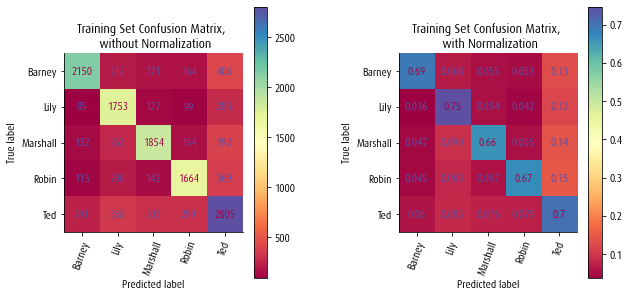

Cohen's Kappa Score for Training Set:
0.614
Matthew's Correlation Coefficient for Training Set:
0.615
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.26      0.29      1529
        Lily       0.24      0.28      0.26      1156
    Marshall       0.28      0.24      0.26      1377
       Robin       0.23      0.22      0.23      1229
         Ted       0.33      0.37      0.35      1963

    accuracy                           0.29      7254
   macro avg       0.28      0.28      0.28      7254
weighted avg       0.29      0.29      0.28      7254



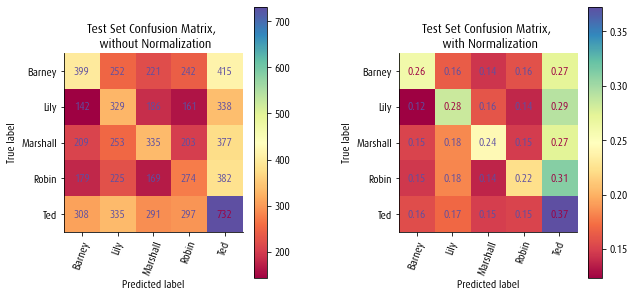

Cohen's Kappa Score for Test Set:
0.096
Matthew's Correlation Coefficient for Test Set:
0.096


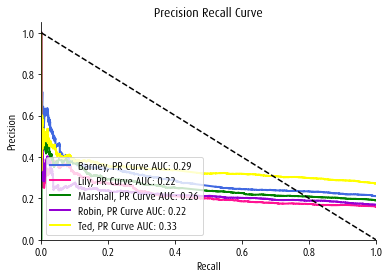

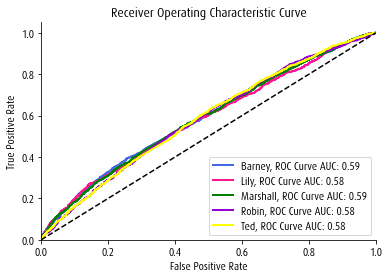

Model Name                            T10LRTF
Accuracy Score                       0.285222
Precision Score                      0.279253
Recall Score                         0.276937
F1 Score                             0.276418
Cohen's Kappa Score                     0.096
Matthew's Correlation Coefficient       0.096
dtype: object

In [33]:
T10LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T10LRpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'T10LRTF')
scoretable.loc['22'] = Report
Report

## Multinomial Naive Bayes using Count Vectorizer

We'll be tuning three models:

* Alpha = 0.001
* Alpha = 0.01
* Alpha = 0.1

### Tuned Model 11: Alpha 0.001

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.71      0.61      0.66      3103
        Lily       0.68      0.58      0.62      2347
    Marshall       0.70      0.56      0.62      2795
       Robin       0.66      0.53      0.59      2496
         Ted       0.52      0.77      0.62      3986

    accuracy                           0.62     14727
   macro avg       0.66      0.61      0.62     14727
weighted avg       0.65      0.62      0.62     14727



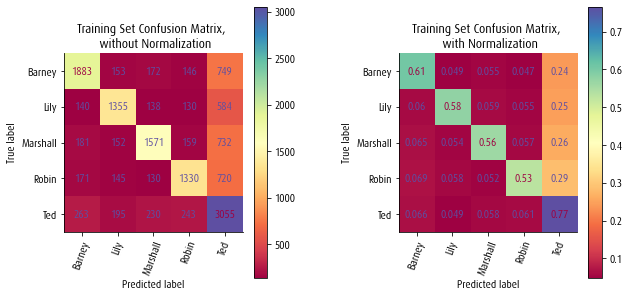

Cohen's Kappa Score for Training Set:
0.519
Matthew's Correlation Coefficient for Training Set:
0.526
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.33      0.27      0.30      1529
        Lily       0.31      0.23      0.26      1156
    Marshall       0.30      0.24      0.26      1377
       Robin       0.26      0.21      0.23      1229
         Ted       0.33      0.52      0.40      1963

    accuracy                           0.31      7254
   macro avg       0.31      0.29      0.29      7254
weighted avg       0.31      0.31      0.30      7254



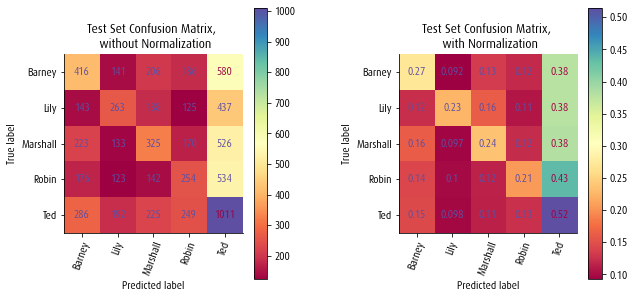

Cohen's Kappa Score for Test Set:
0.117
Matthew's Correlation Coefficient for Test Set:
0.12


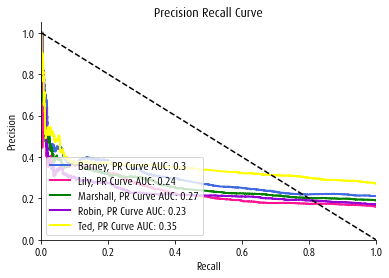

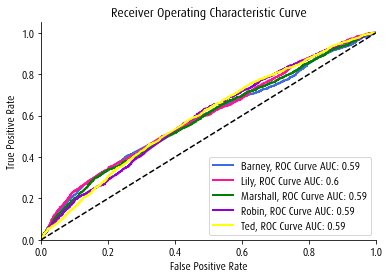

Model Name                           T11MNBCV
Accuracy Score                       0.312793
Precision Score                      0.305576
Recall Score                          0.29146
F1 Score                             0.291153
Cohen's Kappa Score                     0.117
Matthew's Correlation Coefficient        0.12
dtype: object

In [34]:
T11MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB(alpha = 0.001)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T11MNBpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T11MNBCV')
scoretable.loc['23'] = Report
Report

### Tuned Model 12: Alpha = 0.01

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.71      0.61      0.66      3103
        Lily       0.68      0.58      0.62      2347
    Marshall       0.70      0.56      0.62      2795
       Robin       0.66      0.53      0.59      2496
         Ted       0.52      0.77      0.62      3986

    accuracy                           0.62     14727
   macro avg       0.66      0.61      0.62     14727
weighted avg       0.65      0.62      0.62     14727



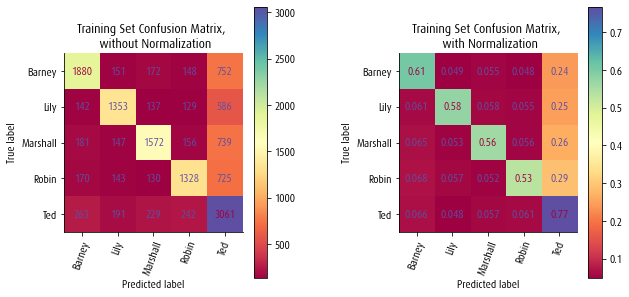

Cohen's Kappa Score for Training Set:
0.519
Matthew's Correlation Coefficient for Training Set:
0.526
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.27      0.30      1529
        Lily       0.31      0.23      0.26      1156
    Marshall       0.30      0.24      0.27      1377
       Robin       0.26      0.21      0.23      1229
         Ted       0.33      0.52      0.40      1963

    accuracy                           0.31      7254
   macro avg       0.31      0.29      0.29      7254
weighted avg       0.31      0.31      0.30      7254



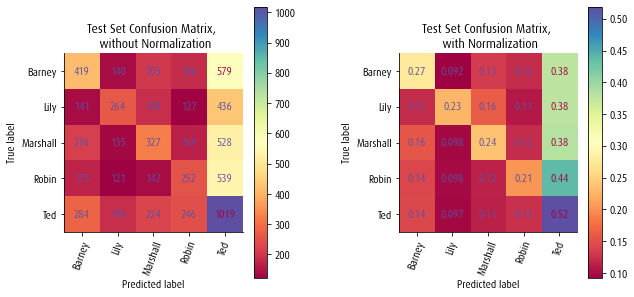

Cohen's Kappa Score for Test Set:
0.119
Matthew's Correlation Coefficient for Test Set:
0.122


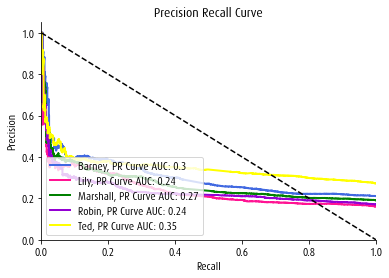

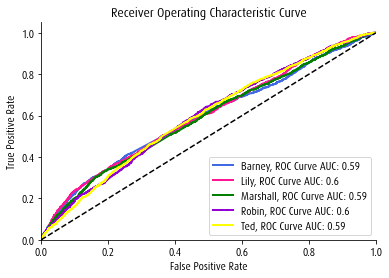

Model Name                           T12MNBCV
Accuracy Score                       0.314447
Precision Score                      0.307232
Recall Score                         0.292806
F1 Score                             0.292462
Cohen's Kappa Score                     0.119
Matthew's Correlation Coefficient       0.122
dtype: object

In [35]:
T12MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB(alpha = 0.01)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T12MNBpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T12MNBCV')
scoretable.loc['24'] = Report
Report

### Tuned Model 13: Alpha = 0.1

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.70      0.60      0.65      3103
        Lily       0.70      0.56      0.62      2347
    Marshall       0.70      0.55      0.62      2795
       Robin       0.68      0.51      0.58      2496
         Ted       0.51      0.79      0.62      3986

    accuracy                           0.62     14727
   macro avg       0.66      0.60      0.62     14727
weighted avg       0.65      0.62      0.62     14727



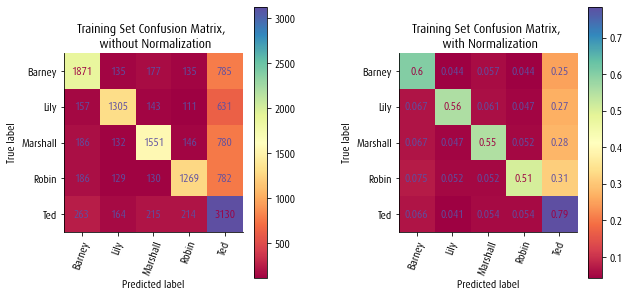

Cohen's Kappa Score for Training Set:
0.512
Matthew's Correlation Coefficient for Training Set:
0.521
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.27      0.30      1529
        Lily       0.30      0.21      0.25      1156
    Marshall       0.31      0.24      0.27      1377
       Robin       0.26      0.20      0.22      1229
         Ted       0.33      0.54      0.41      1963

    accuracy                           0.32      7254
   macro avg       0.31      0.29      0.29      7254
weighted avg       0.31      0.32      0.30      7254



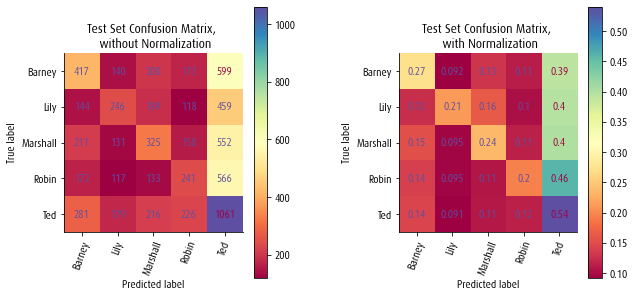

Cohen's Kappa Score for Test Set:
0.119
Matthew's Correlation Coefficient for Test Set:
0.122


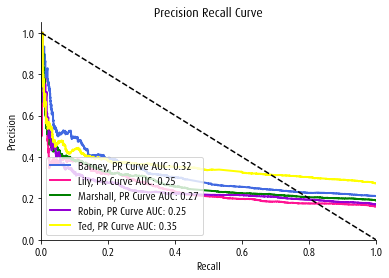

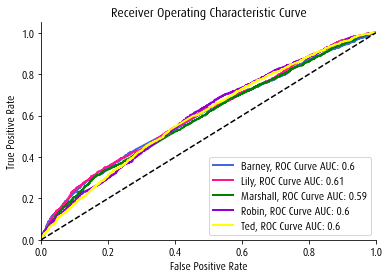

Model Name                           T13MNBCV
Accuracy Score                       0.315688
Precision Score                      0.307921
Recall Score                         0.291629
F1 Score                             0.290377
Cohen's Kappa Score                     0.119
Matthew's Correlation Coefficient       0.122
dtype: object

In [36]:
T13MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB(alpha = 0.1)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T13MNBpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T13MNBCV')
scoretable.loc['25'] = Report
Report

## Random Forest using Count Vectorizer

We'll be tuning five models:

* Class Weight = Balanced
* Number of Estimators = 10
* Number of Estimators = 50
* Class Weight = Balanced; Number of Estimators = 10
* Class Weight = Balanced; Number of Estimators = 50

### Tuned Model 14: Class Weight = Balanced

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.89      0.91      3103
        Lily       0.88      0.88      0.88      2347
    Marshall       0.95      0.86      0.90      2795
       Robin       0.72      0.92      0.81      2496
         Ted       0.93      0.86      0.89      3986

    accuracy                           0.88     14727
   macro avg       0.88      0.88      0.88     14727
weighted avg       0.89      0.88      0.88     14727



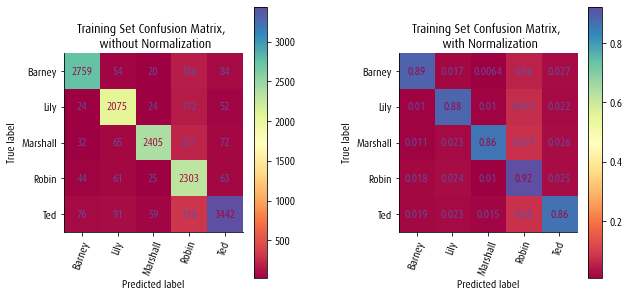

Cohen's Kappa Score for Training Set:
0.851
Matthew's Correlation Coefficient for Training Set:
0.853
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.31      0.26      0.28      1529
        Lily       0.25      0.26      0.25      1156
    Marshall       0.28      0.23      0.25      1377
       Robin       0.22      0.30      0.26      1229
         Ted       0.34      0.34      0.34      1963

    accuracy                           0.28      7254
   macro avg       0.28      0.28      0.28      7254
weighted avg       0.29      0.28      0.28      7254



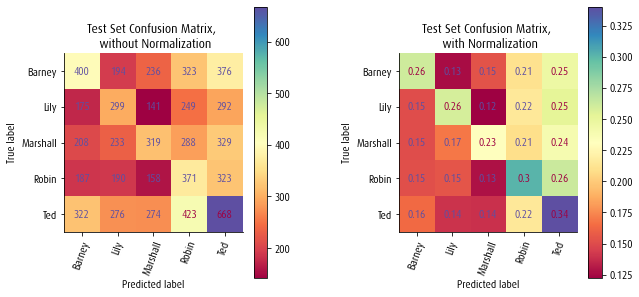

Cohen's Kappa Score for Test Set:
0.098
Matthew's Correlation Coefficient for Test Set:
0.098


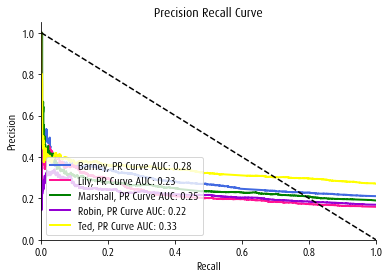

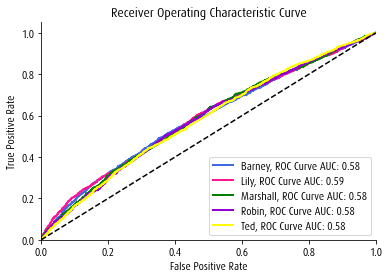

Model Name                            T14RFCV
Accuracy Score                       0.283568
Precision Score                      0.280712
Recall Score                         0.278818
F1 Score                             0.277695
Cohen's Kappa Score                     0.098
Matthew's Correlation Coefficient       0.098
dtype: object

In [37]:
T14RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T14RFpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T14RFCV')
scoretable.loc['26'] = Report
Report

### Tuned Model 15: Number of Estimators = 10

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.92      0.88      0.90      3103
        Lily       0.92      0.84      0.88      2347
    Marshall       0.94      0.84      0.89      2795
       Robin       0.91      0.83      0.87      2496
         Ted       0.77      0.94      0.85      3986

    accuracy                           0.87     14727
   macro avg       0.89      0.87      0.88     14727
weighted avg       0.88      0.87      0.87     14727



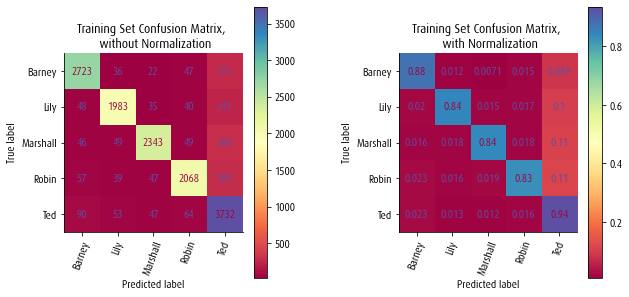

Cohen's Kappa Score for Training Set:
0.838
Matthew's Correlation Coefficient for Training Set:
0.84
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.29      0.25      0.27      1529
        Lily       0.25      0.23      0.24      1156
    Marshall       0.28      0.23      0.26      1377
       Robin       0.23      0.18      0.21      1229
         Ted       0.32      0.46      0.38      1963

    accuracy                           0.29      7254
   macro avg       0.28      0.27      0.27      7254
weighted avg       0.28      0.29      0.28      7254



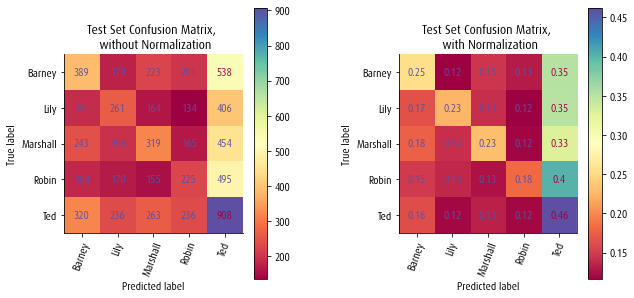

Cohen's Kappa Score for Test Set:
0.092
Matthew's Correlation Coefficient for Test Set:
0.093


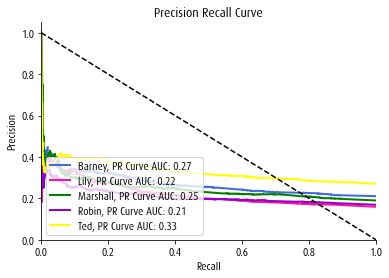

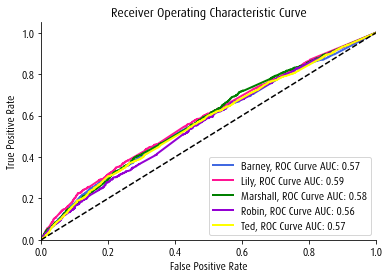

Model Name                            T15RFCV
Accuracy Score                       0.289771
Precision Score                      0.277194
Recall Score                         0.271498
F1 Score                             0.270355
Cohen's Kappa Score                     0.092
Matthew's Correlation Coefficient       0.093
dtype: object

In [38]:
T15RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T15RFpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T15RFCV')
scoretable.loc['27'] = Report
Report

### Tuned Model 16: Number of Estimators = 50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.88      0.91      3103
        Lily       0.94      0.86      0.90      2347
    Marshall       0.95      0.86      0.90      2795
       Robin       0.93      0.85      0.89      2496
         Ted       0.78      0.95      0.86      3986

    accuracy                           0.89     14727
   macro avg       0.91      0.88      0.89     14727
weighted avg       0.90      0.89      0.89     14727



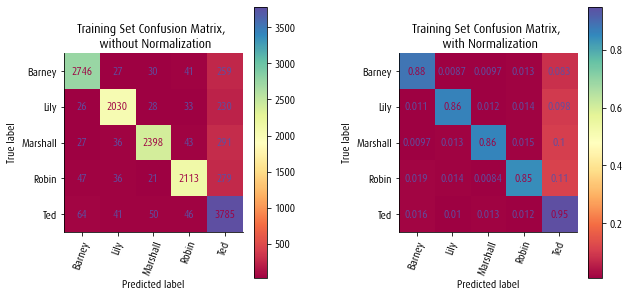

Cohen's Kappa Score for Training Set:
0.857
Matthew's Correlation Coefficient for Training Set:
0.86
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.31      0.25      0.28      1529
        Lily       0.26      0.24      0.25      1156
    Marshall       0.28      0.22      0.25      1377
       Robin       0.26      0.19      0.22      1229
         Ted       0.33      0.48      0.39      1963

    accuracy                           0.30      7254
   macro avg       0.29      0.28      0.28      7254
weighted avg       0.29      0.30      0.29      7254



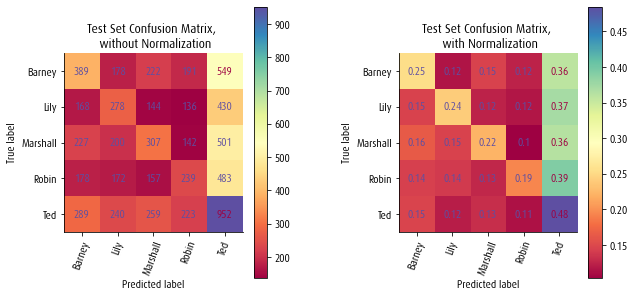

Cohen's Kappa Score for Test Set:
0.102
Matthew's Correlation Coefficient for Test Set:
0.103


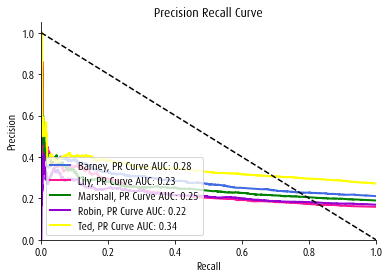

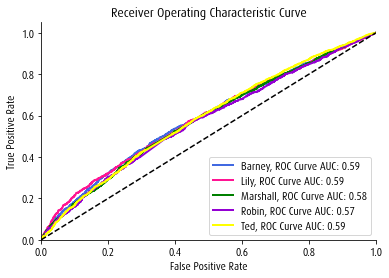

Model Name                            T16RFCV
Accuracy Score                       0.298456
Precision Score                      0.287292
Recall Score                         0.279457
F1 Score                             0.278093
Cohen's Kappa Score                     0.102
Matthew's Correlation Coefficient       0.103
dtype: object

In [39]:
T16RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T16RFpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T16RFCV')
scoretable.loc['28'] = Report
Report

### Tuned Model 17: Class Weight = Balanced, Number of Estimators = 10

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.93      0.87      0.90      3103
        Lily       0.88      0.87      0.88      2347
    Marshall       0.93      0.85      0.89      2795
       Robin       0.71      0.91      0.79      2496
         Ted       0.91      0.86      0.88      3986

    accuracy                           0.87     14727
   macro avg       0.87      0.87      0.87     14727
weighted avg       0.88      0.87      0.87     14727



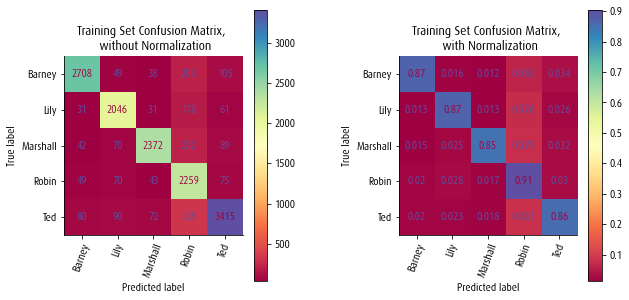

Cohen's Kappa Score for Training Set:
0.835
Matthew's Correlation Coefficient for Training Set:
0.837
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.31      0.26      0.28      1529
        Lily       0.24      0.24      0.24      1156
    Marshall       0.27      0.23      0.25      1377
       Robin       0.22      0.31      0.26      1229
         Ted       0.33      0.31      0.32      1963

    accuracy                           0.28      7254
   macro avg       0.27      0.27      0.27      7254
weighted avg       0.28      0.28      0.28      7254



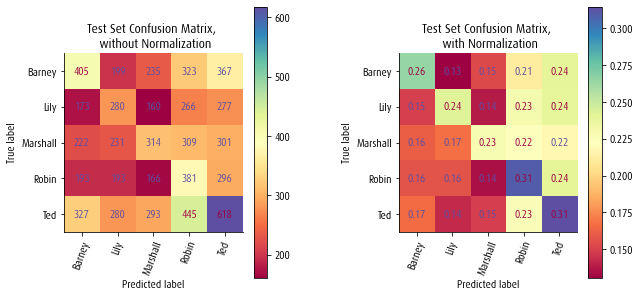

Cohen's Kappa Score for Test Set:
0.089
Matthew's Correlation Coefficient for Test Set:
0.09


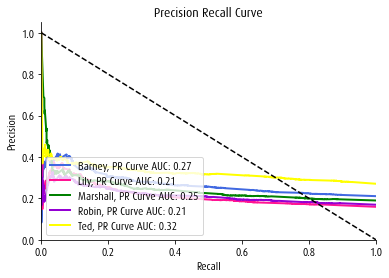

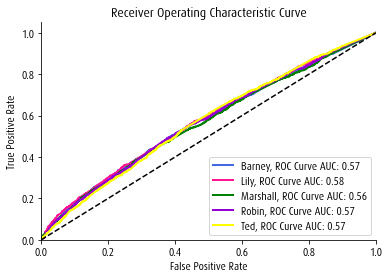

Model Name                            T17RFCV
Accuracy Score                       0.275434
Precision Score                      0.273155
Recall Score                         0.271992
F1 Score                             0.270384
Cohen's Kappa Score                     0.089
Matthew's Correlation Coefficient        0.09
dtype: object

In [40]:
T17RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T17RFpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T17RFCV')
scoretable.loc['29'] = Report
Report

### Tuned Model 18: Class Weight = Balanced; Number of Estimators = 50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.89      0.91      3103
        Lily       0.90      0.88      0.89      2347
    Marshall       0.95      0.86      0.90      2795
       Robin       0.71      0.93      0.80      2496
         Ted       0.93      0.86      0.89      3986

    accuracy                           0.88     14727
   macro avg       0.89      0.88      0.88     14727
weighted avg       0.89      0.88      0.88     14727



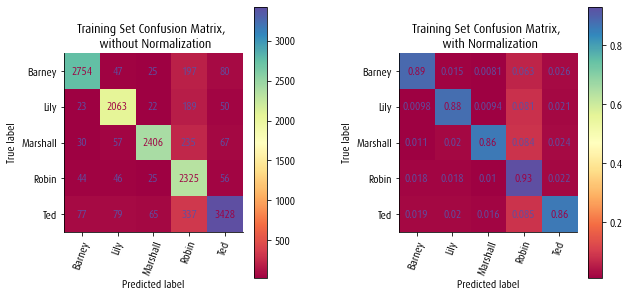

Cohen's Kappa Score for Training Set:
0.85
Matthew's Correlation Coefficient for Training Set:
0.852
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.30      0.26      0.28      1529
        Lily       0.25      0.25      0.25      1156
    Marshall       0.28      0.24      0.26      1377
       Robin       0.23      0.31      0.27      1229
         Ted       0.33      0.32      0.32      1963

    accuracy                           0.28      7254
   macro avg       0.28      0.28      0.27      7254
weighted avg       0.28      0.28      0.28      7254



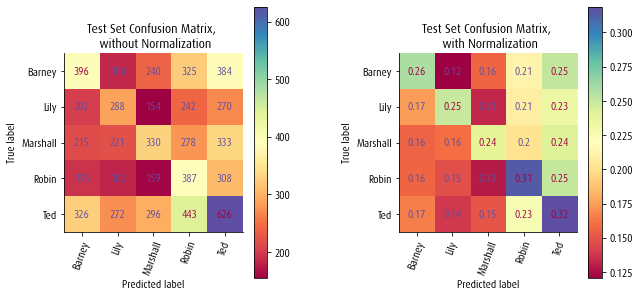

Cohen's Kappa Score for Test Set:
0.093
Matthew's Correlation Coefficient for Test Set:
0.093


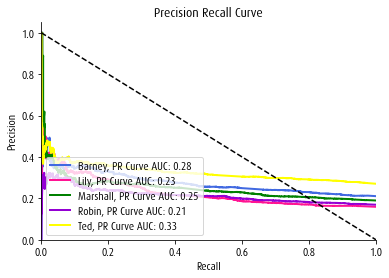

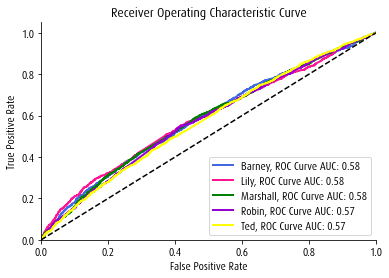

Model Name                            T18RFCV
Accuracy Score                       0.279432
Precision Score                       0.27704
Recall Score                         0.276314
F1 Score                             0.274806
Cohen's Kappa Score                     0.093
Matthew's Correlation Coefficient       0.093
dtype: object

In [41]:
T18RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T18RFpipelineCV, X_train, y_train_enc, X_test, y_test_enc, name = 'T18RFCV')
scoretable.loc['30'] = Report
Report

## Random Forest using TF-IDF Vectorizer

### Tuning Model 19: Class Weight = Balanced

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.89      0.91      3103
        Lily       0.89      0.88      0.89      2347
    Marshall       0.94      0.86      0.90      2795
       Robin       0.71      0.93      0.80      2496
         Ted       0.93      0.86      0.89      3986

    accuracy                           0.88     14727
   macro avg       0.88      0.88      0.88     14727
weighted avg       0.89      0.88      0.88     14727



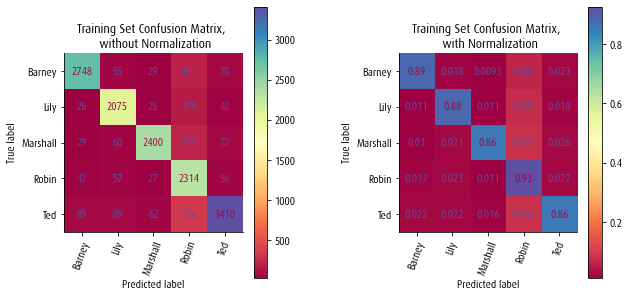

Cohen's Kappa Score for Training Set:
0.848
Matthew's Correlation Coefficient for Training Set:
0.85
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.30      0.31      1529
        Lily       0.26      0.19      0.22      1156
    Marshall       0.28      0.21      0.24      1377
       Robin       0.24      0.27      0.25      1229
         Ted       0.32      0.42      0.37      1963

    accuracy                           0.29      7254
   macro avg       0.28      0.28      0.28      7254
weighted avg       0.29      0.29      0.29      7254



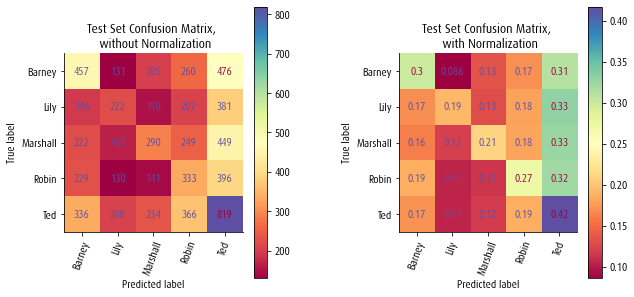

Cohen's Kappa Score for Test Set:
0.099
Matthew's Correlation Coefficient for Test Set:
0.1


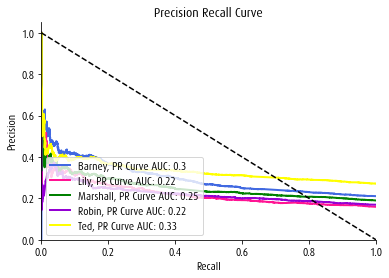

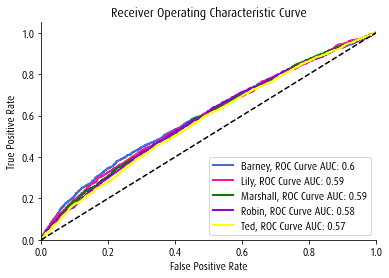

Model Name                            T19RFTF
Accuracy Score                        0.29239
Precision Score                      0.284125
Recall Score                         0.277941
F1 Score                             0.277493
Cohen's Kappa Score                     0.099
Matthew's Correlation Coefficient         0.1
dtype: object

In [42]:
T19RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T19RFpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'T19RFTF')
scoretable.loc['31'] = Report
Report

### Tuned Model 20: Number of Estimators = 10

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.91      0.88      0.90      3103
        Lily       0.92      0.85      0.88      2347
    Marshall       0.93      0.84      0.89      2795
       Robin       0.94      0.82      0.87      2496
         Ted       0.77      0.94      0.85      3986

    accuracy                           0.87     14727
   macro avg       0.90      0.87      0.88     14727
weighted avg       0.88      0.87      0.88     14727



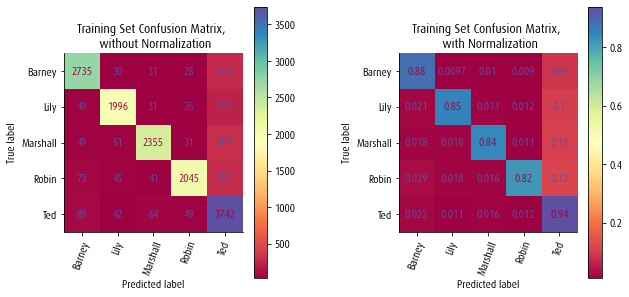

Cohen's Kappa Score for Training Set:
0.84
Matthew's Correlation Coefficient for Training Set:
0.842
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.31      0.30      0.31      1529
        Lily       0.24      0.19      0.21      1156
    Marshall       0.27      0.21      0.24      1377
       Robin       0.25      0.17      0.20      1229
         Ted       0.32      0.46      0.37      1963

    accuracy                           0.29      7254
   macro avg       0.28      0.27      0.27      7254
weighted avg       0.28      0.29      0.28      7254



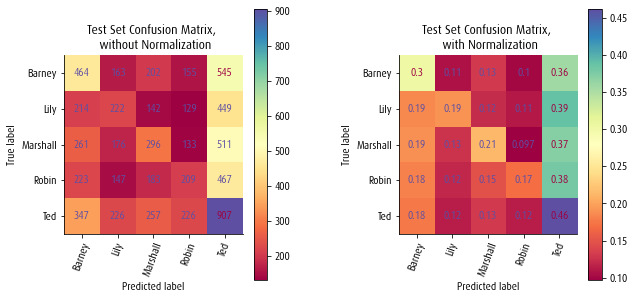

Cohen's Kappa Score for Test Set:
0.089
Matthew's Correlation Coefficient for Test Set:
0.09


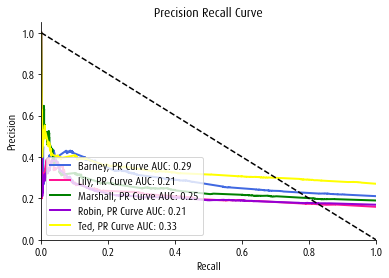

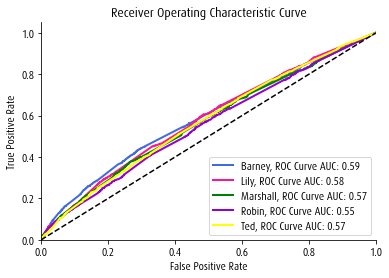

Model Name                            T20RFTF
Accuracy Score                        0.28922
Precision Score                      0.275919
Recall Score                         0.268515
F1 Score                              0.26687
Cohen's Kappa Score                     0.089
Matthew's Correlation Coefficient        0.09
dtype: object

In [43]:
T20RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T20RFpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'T20RFTF')
scoretable.loc['32'] = Report
Report

### Tuned Model 21: Number of Estimators = 50

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.95      0.88      0.91      3103
        Lily       0.94      0.86      0.90      2347
    Marshall       0.96      0.85      0.90      2795
       Robin       0.92      0.84      0.88      2496
         Ted       0.77      0.95      0.85      3986

    accuracy                           0.89     14727
   macro avg       0.91      0.88      0.89     14727
weighted avg       0.90      0.89      0.89     14727



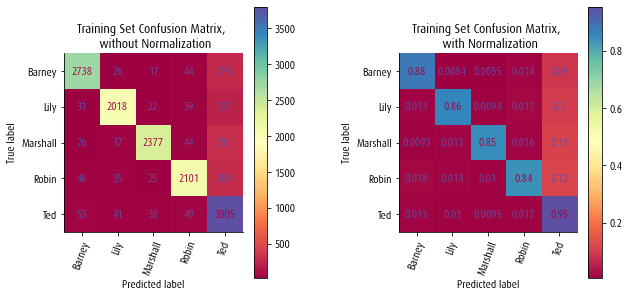

Cohen's Kappa Score for Training Set:
0.854
Matthew's Correlation Coefficient for Training Set:
0.857
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.32      0.30      0.31      1529
        Lily       0.28      0.19      0.23      1156
    Marshall       0.30      0.20      0.24      1377
       Robin       0.27      0.16      0.20      1229
         Ted       0.32      0.55      0.40      1963

    accuracy                           0.31      7254
   macro avg       0.30      0.28      0.28      7254
weighted avg       0.30      0.31      0.29      7254



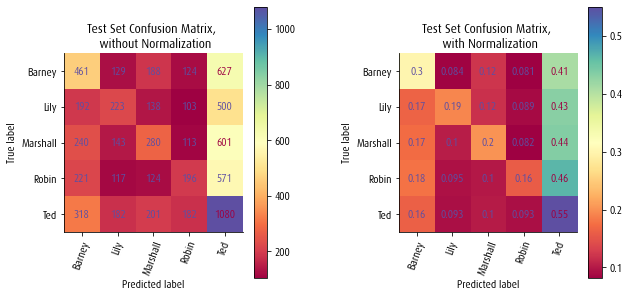

Cohen's Kappa Score for Test Set:
0.107
Matthew's Correlation Coefficient for Test Set:
0.11


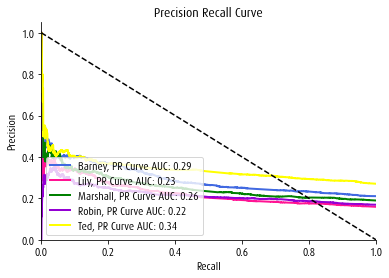

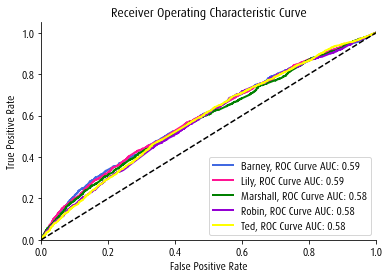

Model Name                            T21RFTF
Accuracy Score                       0.308795
Precision Score                      0.299227
Recall Score                         0.281482
F1 Score                             0.277682
Cohen's Kappa Score                     0.107
Matthew's Correlation Coefficient        0.11
dtype: object

In [44]:
T21RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50)), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T21RFpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'T21RFTF')
scoretable.loc['33'] = Report
Report

### Tuned Model 22: Class Weight = Balanced; Number of Estimators = 10

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.93      0.88      0.90      3103
        Lily       0.89      0.86      0.87      2347
    Marshall       0.94      0.84      0.89      2795
       Robin       0.70      0.91      0.79      2496
         Ted       0.91      0.86      0.88      3986

    accuracy                           0.87     14727
   macro avg       0.87      0.87      0.87     14727
weighted avg       0.88      0.87      0.87     14727



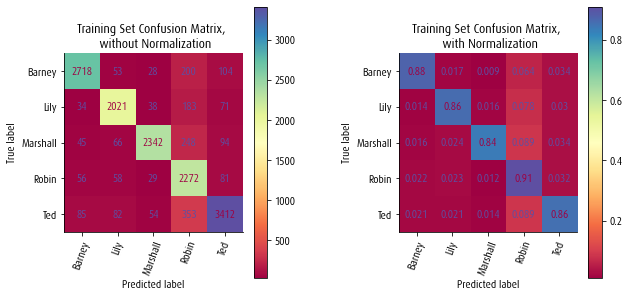

Cohen's Kappa Score for Training Set:
0.832
Matthew's Correlation Coefficient for Training Set:
0.834
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.30      0.31      0.31      1529
        Lily       0.23      0.20      0.22      1156
    Marshall       0.28      0.20      0.23      1377
       Robin       0.23      0.28      0.25      1229
         Ted       0.31      0.35      0.33      1963

    accuracy                           0.28      7254
   macro avg       0.27      0.27      0.27      7254
weighted avg       0.28      0.28      0.27      7254



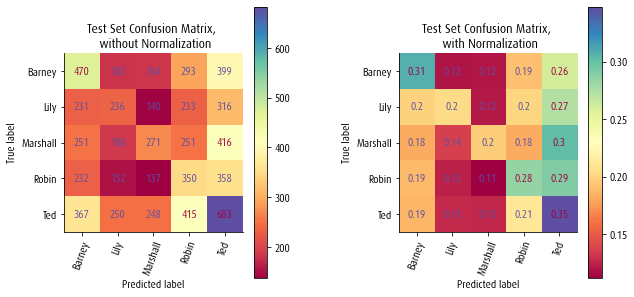

Cohen's Kappa Score for Test Set:
0.085
Matthew's Correlation Coefficient for Test Set:
0.085


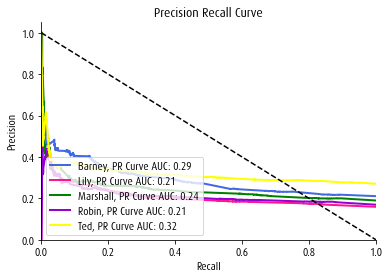

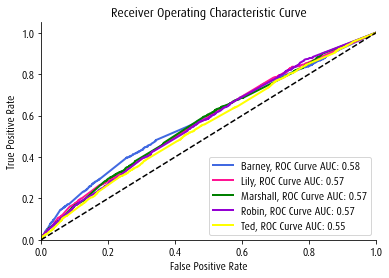

Model Name                            T22RFTF
Accuracy Score                       0.277089
Precision Score                      0.270978
Recall Score                         0.268214
F1 Score                             0.267226
Cohen's Kappa Score                     0.085
Matthew's Correlation Coefficient       0.085
dtype: object

In [45]:
T22RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T22RFpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'T22RFTF')
scoretable.loc['34'] = Report
Report

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.94      0.88      0.91      3103
        Lily       0.90      0.88      0.89      2347
    Marshall       0.95      0.86      0.90      2795
       Robin       0.70      0.93      0.80      2496
         Ted       0.93      0.86      0.89      3986

    accuracy                           0.88     14727
   macro avg       0.88      0.88      0.88     14727
weighted avg       0.89      0.88      0.88     14727



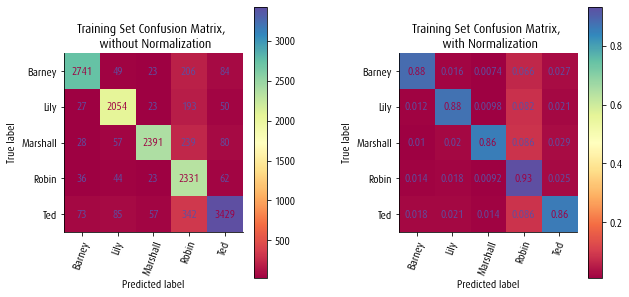

Cohen's Kappa Score for Training Set:
0.848
Matthew's Correlation Coefficient for Training Set:
0.85
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.33      0.30      0.32      1529
        Lily       0.25      0.19      0.22      1156
    Marshall       0.29      0.22      0.25      1377
       Robin       0.23      0.27      0.25      1229
         Ted       0.33      0.42      0.37      1963

    accuracy                           0.29      7254
   macro avg       0.29      0.28      0.28      7254
weighted avg       0.29      0.29      0.29      7254



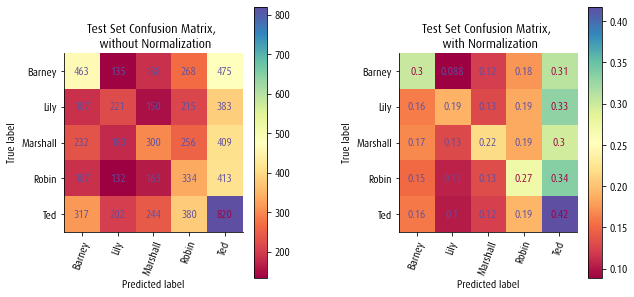

Cohen's Kappa Score for Test Set:
0.103
Matthew's Correlation Coefficient for Test Set:
0.103


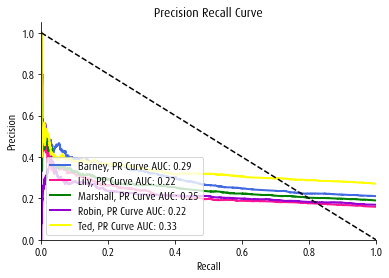

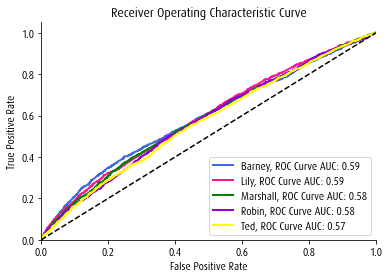

Model Name                            T23RFTF
Accuracy Score                       0.294734
Precision Score                      0.286606
Recall Score                         0.280269
F1 Score                             0.280019
Cohen's Kappa Score                     0.103
Matthew's Correlation Coefficient       0.103
dtype: object

In [46]:
T23RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(T23RFpipelineTF, X_train, y_train_enc, X_test, y_test_enc, name = 'T23RFTF')
scoretable.loc['35'] = Report
Report

# Comparing Tuned Models

Let's compare our tuned model scores on our Cohen's Kappa metric.

In [47]:
scoretable.sort_values(by = ["Cohen's Kappa Score"], ascending = False) #Comparing tuned models

Model Name Accuracy Score Precision Score Recall Score  F1 Score  \
14     T2LRCV       0.324648        0.319861     0.294803  0.291302   
1    LogRegCV       0.318583        0.309874     0.291955  0.289549   
16     T4LRCV       0.296664        0.300735     0.298236  0.294639   
25   T13MNBCV       0.315688        0.307921     0.291629  0.290377   
24   T12MNBCV       0.314447        0.307232     0.292806  0.292462   
23   T11MNBCV       0.312793        0.305576      0.29146  0.291153   
13     T1LRCV       0.292666        0.296647     0.293983  0.290717   
2    LogRegTF       0.318583        0.311445     0.286829  0.281198   
18     T6LRTF        0.29818        0.292842     0.292515  0.292293   
21     T9LRTF       0.295148        0.289932     0.290122  0.289745   
3       MNBCV       0.321478        0.328686     0.280901  0.267632   
15     T3LRCV        0.30204        0.290847     0.283361  0.282918   
33    T21RFTF       0.308795        0.299227     0.281482  0.277682   
20     T8LRTF        0.29694        0.287036     0.282244  0.282753   
19     T7LRTF        0.31748        0.317478     0.277655  0.264133   
35    T23RFTF       0.294734        0.286606     0.280269  0.280019   
28    T16RFCV       0.298456        0.287292     0.279457  0.278093   
17     T5LRCV       0.280397        0.284397     0.282528   0.27851   
31    T19RFTF        0.29239        0.284125     0.277941  0.277493   
7        RFCV        0.29625         0.28693     0.277173   0.27641   
26    T14RFCV       0.283568        0.280712     0.278818  0.277695   
22    T10LRTF       0.285222        0.279253     0.276937  0.276418   
8        RFTF       0.299007         0.28825     0.271989  0.267988   
30    T18RFCV       0.279432         0.27704     0.276314  0.274806   
27    T15RFCV       0.289771        0.277194     0.271498  0.270355   
32    T20RFTF        0.28922        0.275919     0.268515   0.26687   
29    T17RFCV       0.275434        0.273155     0.271992  0.270384   
9        DTCV       0.281362        0.270593     0.267225  0.266286   
34    T22RFTF       0.277089        0.270978     0.268214  0.267226   
10       DTTF       0.282465        0.267241     0.262769   0.26091   
4       MNBTF       0.310725        0.354455     0.256055    0.2185   
12       ABTF       0.305624        0.375441     0.248351  0.200747   
11       ABCV       0.303557        0.391159     0.241644  0.183327   
5       KNNCV        0.23394        0.230286     0.228989  0.228425   
6       KNNTF        0.23587        0.221407     0.221723  0.220849   

   Cohen's Kappa Score Matthew's Correlation Coefficient  
14               0.125                              0.13  
1                0.121                             0.124  
16               0.121                             0.122  
25               0.119                             0.122  
24               0.119                             0.122  
23               0.117                              0.12  
13               0.116                             0.117  
2                0.116                             0.121  
18               0.115                             0.115  
21               0.111                             0.111  
3                 0.11                             0.121  
15               0.108                             0.109  
33               0.107                              0.11  
20               0.105                             0.105  
19               0.105                             0.115  
35               0.103                             0.103  
28               0.102                             0.103  
17               0.101                             0.102  
31               0.099                               0.1  
7                0.098                               0.1  
26               0.098                             0.098  
22               0.096                             0.096  
8                0.094                             0.097  
30               0.093        

So we have our top performing models, but the numbers don't vary too far from our original baseline models. The best model *Logistic Regression using Count Vectorizer with C = 0.5* yielded a Cohen's Kappa score of .125 and an accuracy of 0.32; so it only did slightly better than the original model's Cohen's Kappa score of 0.121, but the accuracy remained the same. Virtually all the tuned models did just slightly better, which is an improvement considering how imbalanced the data was AND how similar each of the character's vocabulary was.

Let's try out some more tuning on our top performing model, and see if we're able to get some better results.

# Hyperparameter Tuning with our Top Model

In the following cells I try a few more different parameters and see if and how that changes our results.

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.48      0.42      0.45      3103
        Lily       0.60      0.18      0.28      2347
    Marshall       0.51      0.29      0.37      2795
       Robin       0.53      0.19      0.28      2496
         Ted       0.37      0.81      0.50      3986

    accuracy                           0.42     14727
   macro avg       0.50      0.38      0.38     14727
weighted avg       0.48      0.42      0.39     14727



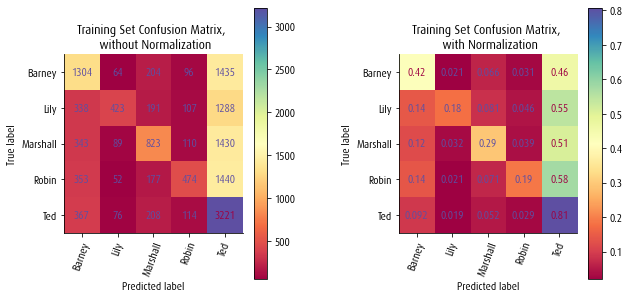

Cohen's Kappa Score for Training Set:
0.243
Matthew's Correlation Coefficient for Training Set:
0.27
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.29      0.31      1529
        Lily       0.42      0.11      0.18      1156
    Marshall       0.30      0.17      0.22      1377
       Robin       0.27      0.09      0.13      1229
         Ted       0.31      0.70      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.27      0.25      7254
weighted avg       0.32      0.32      0.27      7254



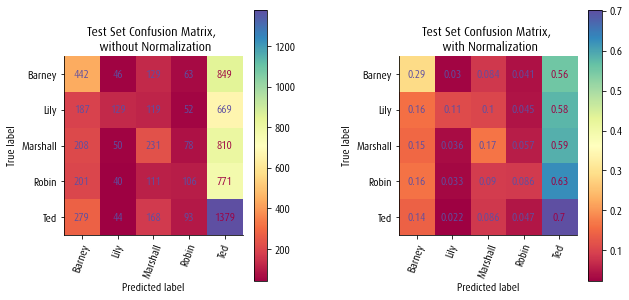

Cohen's Kappa Score for Test Set:
0.098
Matthew's Correlation Coefficient for Test Set:
0.11


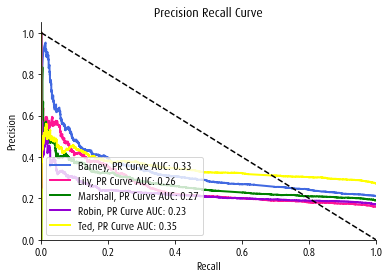

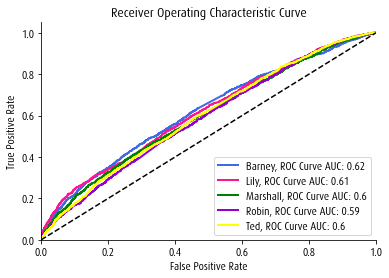

Model Name                                HT1
Accuracy Score                       0.315274
Precision Score                      0.327239
Recall Score                         0.271434
F1 Score                             0.252418
Cohen's Kappa Score                     0.098
Matthew's Correlation Coefficient        0.11
dtype: object

In [48]:
HT1 = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 100, penalty = 'l1', solver = 'saga')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(HT1, X_train, y_train_enc, X_test, y_test_enc, name = 'HT1')
scoretable.loc['36'] = Report
Report

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.47      0.41      0.44      3103
        Lily       0.59      0.17      0.27      2347
    Marshall       0.50      0.28      0.36      2795
       Robin       0.51      0.18      0.27      2496
         Ted       0.36      0.81      0.50      3986

    accuracy                           0.42     14727
   macro avg       0.49      0.37      0.37     14727
weighted avg       0.47      0.42      0.39     14727



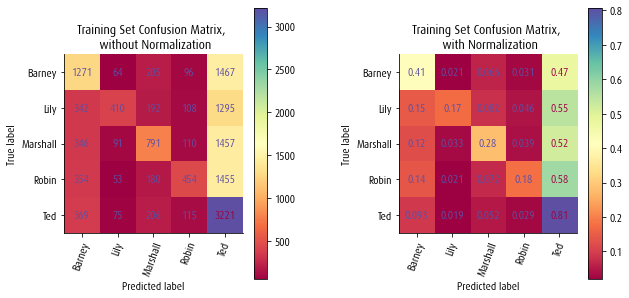

Cohen's Kappa Score for Training Set:
0.234
Matthew's Correlation Coefficient for Training Set:
0.261
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.29      0.31      1529
        Lily       0.41      0.11      0.17      1156
    Marshall       0.30      0.16      0.21      1377
       Robin       0.28      0.09      0.13      1229
         Ted       0.31      0.71      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.27      0.25      7254
weighted avg       0.32      0.32      0.27      7254



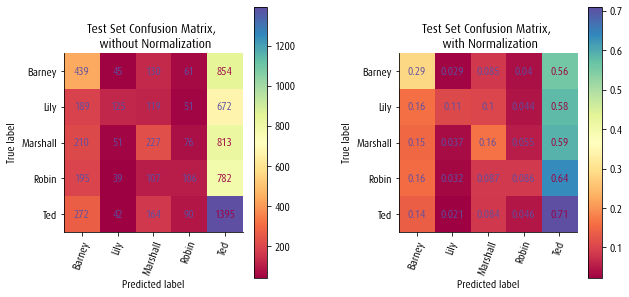

Cohen's Kappa Score for Test Set:
0.098
Matthew's Correlation Coefficient for Test Set:
0.111


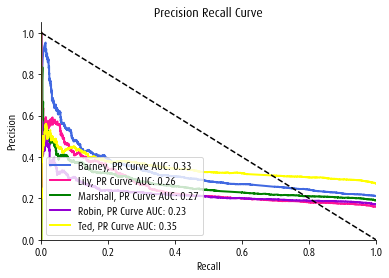

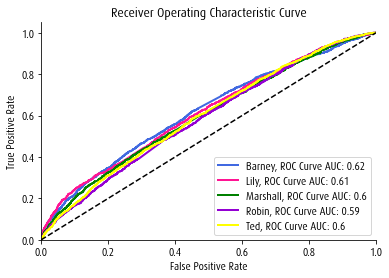

Model Name                                HT2
Accuracy Score                       0.315964
Precision Score                      0.327826
Recall Score                         0.271399
F1 Score                             0.251416
Cohen's Kappa Score                     0.098
Matthew's Correlation Coefficient       0.111
dtype: object

In [49]:
HT2 = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 10, penalty = 'l1', solver = 'saga')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(HT2, X_train, y_train_enc, X_test, y_test_enc, name = 'HT2')
scoretable.loc['37'] = Report
Report

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.43      0.35      0.38      3103
        Lily       0.52      0.13      0.20      2347
    Marshall       0.45      0.21      0.29      2795
       Robin       0.46      0.12      0.19      2496
         Ted       0.33      0.81      0.47      3986

    accuracy                           0.37     14727
   macro avg       0.44      0.32      0.31     14727
weighted avg       0.43      0.37      0.33     14727



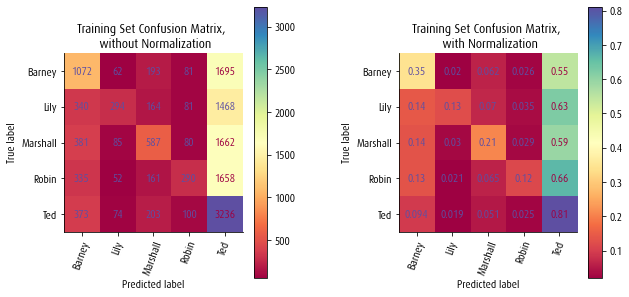

Cohen's Kappa Score for Training Set:
0.169
Matthew's Correlation Coefficient for Training Set:
0.198
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.34      0.27      0.30      1529
        Lily       0.43      0.09      0.15      1156
    Marshall       0.32      0.15      0.20      1377
       Robin       0.28      0.07      0.11      1229
         Ted       0.30      0.76      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.27      0.24      7254
weighted avg       0.33      0.32      0.26      7254



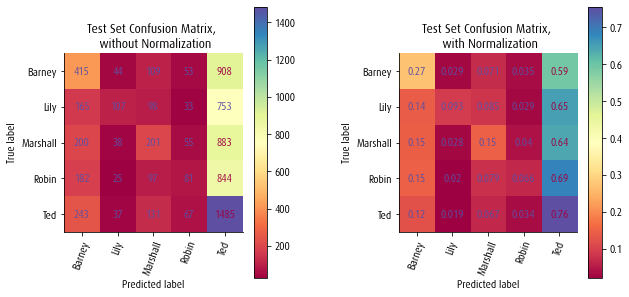

Cohen's Kappa Score for Test Set:
0.093
Matthew's Correlation Coefficient for Test Set:
0.11


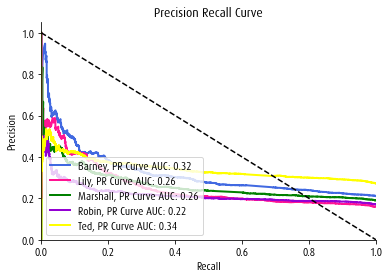

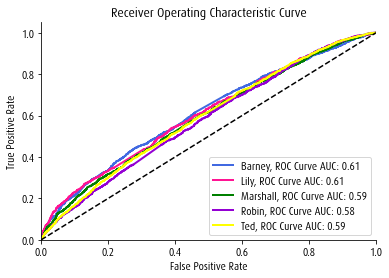

Model Name                                HT3
Accuracy Score                        0.31555
Precision Score                       0.33435
Recall Score                          0.26647
F1 Score                             0.239313
Cohen's Kappa Score                     0.093
Matthew's Correlation Coefficient        0.11
dtype: object

In [50]:
HT3 = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1, penalty = 'l1', solver = 'saga')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(HT3, X_train, y_train_enc, X_test, y_test_enc, name = 'HT3')
scoretable.loc['38'] = Report
Report

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.53      0.48      0.50      3103
        Lily       0.64      0.27      0.38      2347
    Marshall       0.55      0.35      0.43      2795
       Robin       0.56      0.27      0.36      2496
         Ted       0.40      0.80      0.53      3986

    accuracy                           0.47     14727
   macro avg       0.54      0.43      0.44     14727
weighted avg       0.52      0.47      0.45     14727



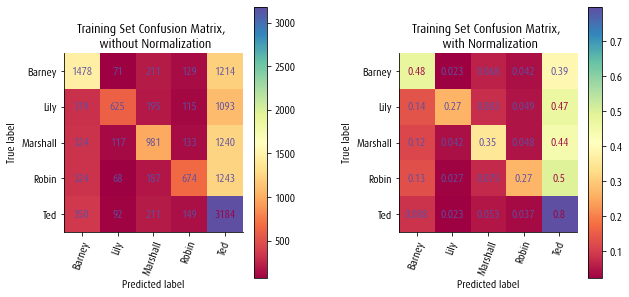

Cohen's Kappa Score for Training Set:
0.31
Matthew's Correlation Coefficient for Training Set:
0.332
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.35      0.31      0.33      1529
        Lily       0.40      0.15      0.21      1156
    Marshall       0.31      0.19      0.24      1377
       Robin       0.28      0.13      0.17      1229
         Ted       0.31      0.66      0.43      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.29      0.28      7254
weighted avg       0.33      0.32      0.29      7254



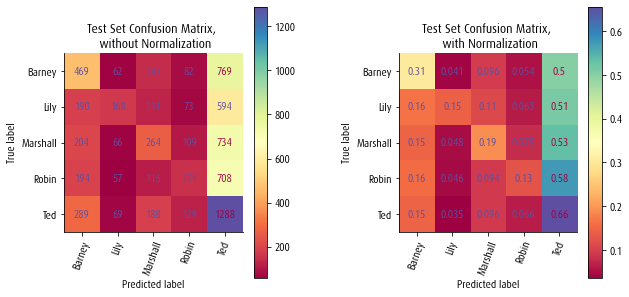

Cohen's Kappa Score for Test Set:
0.114
Matthew's Correlation Coefficient for Test Set:
0.124


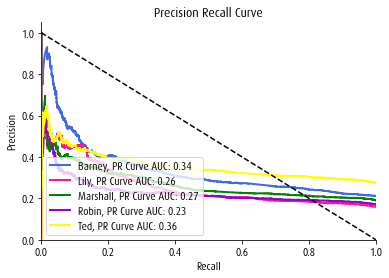

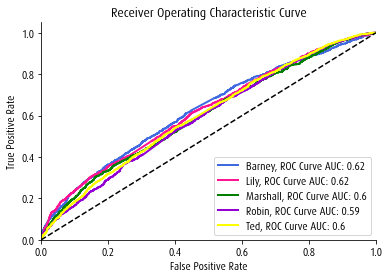

Model Name                                HT4
Accuracy Score                       0.322994
Precision Score                      0.330964
Recall Score                         0.285046
F1 Score                             0.275098
Cohen's Kappa Score                     0.114
Matthew's Correlation Coefficient       0.124
dtype: object

In [51]:
HT4 = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 100, penalty = 'none', solver = 'sag')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(HT4, X_train, y_train_enc, X_test, y_test_enc, name = 'HT4')
scoretable.loc['39'] = Report
Report

Classification Report for Training Set
              precision    recall  f1-score   support

      Barney       0.53      0.48      0.50      3103
        Lily       0.64      0.27      0.38      2347
    Marshall       0.55      0.35      0.43      2795
       Robin       0.56      0.27      0.37      2496
         Ted       0.40      0.80      0.53      3986

    accuracy                           0.47     14727
   macro avg       0.54      0.43      0.44     14727
weighted avg       0.52      0.47      0.45     14727



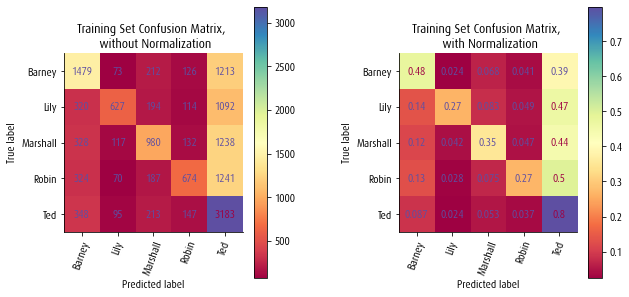

Cohen's Kappa Score for Training Set:
0.31
Matthew's Correlation Coefficient for Training Set:
0.332
Classification Report for Test Set
              precision    recall  f1-score   support

      Barney       0.35      0.30      0.32      1529
        Lily       0.39      0.14      0.21      1156
    Marshall       0.31      0.19      0.23      1377
       Robin       0.28      0.13      0.17      1229
         Ted       0.31      0.66      0.42      1963

    accuracy                           0.32      7254
   macro avg       0.33      0.28      0.27      7254
weighted avg       0.33      0.32      0.29      7254



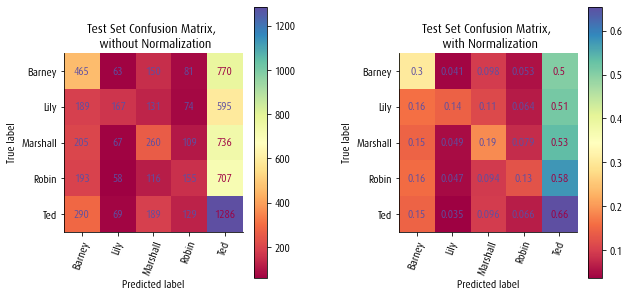

Cohen's Kappa Score for Test Set:
0.112
Matthew's Correlation Coefficient for Test Set:
0.122


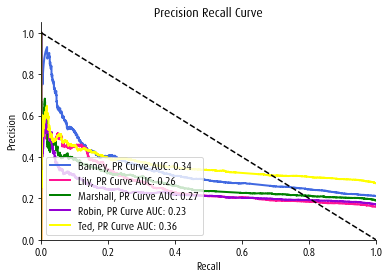

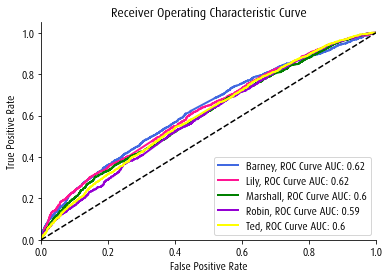

Model Name                                HT5
Accuracy Score                       0.321616
Precision Score                      0.328932
Recall Score                         0.283728
F1 Score                             0.273665
Cohen's Kappa Score                     0.112
Matthew's Correlation Coefficient       0.122
dtype: object

In [52]:
HT5 = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.01, penalty = 'none', solver = 'sag')), 
]) #Creating Logistic Regression pipeline with count vectorizer

Report = fitmodel(HT5, X_train, y_train_enc, X_test, y_test_enc, name = 'HT5')
scoretable.loc['40'] = Report
Report

In [53]:
scoretable.sort_values(by = ["Cohen's Kappa Score"], ascending = False) #Comparing tuned models

Model Name Accuracy Score Precision Score Recall Score  F1 Score  \
14     T2LRCV       0.324648        0.319861     0.294803  0.291302   
1    LogRegCV       0.318583        0.309874     0.291955  0.289549   
16     T4LRCV       0.296664        0.300735     0.298236  0.294639   
25   T13MNBCV       0.315688        0.307921     0.291629  0.290377   
24   T12MNBCV       0.314447        0.307232     0.292806  0.292462   
23   T11MNBCV       0.312793        0.305576      0.29146  0.291153   
13     T1LRCV       0.292666        0.296647     0.293983  0.290717   
2    LogRegTF       0.318583        0.311445     0.286829  0.281198   
18     T6LRTF        0.29818        0.292842     0.292515  0.292293   
39        HT4       0.322994        0.330964     0.285046  0.275098   
40        HT5       0.321616        0.328932     0.283728  0.273665   
21     T9LRTF       0.295148        0.289932     0.290122  0.289745   
3       MNBCV       0.321478        0.328686     0.280901  0.267632   
15     T3LRCV        0.30204        0.290847     0.283361  0.282918   
33    T21RFTF       0.308795        0.299227     0.281482  0.277682   
19     T7LRTF        0.31748        0.317478     0.277655  0.264133   
20     T8LRTF        0.29694        0.287036     0.282244  0.282753   
35    T23RFTF       0.294734        0.286606     0.280269  0.280019   
28    T16RFCV       0.298456        0.287292     0.279457  0.278093   
17     T5LRCV       0.280397        0.284397     0.282528   0.27851   
31    T19RFTF        0.29239        0.284125     0.277941  0.277493   
37        HT2       0.315964        0.327826     0.271399  0.251416   
36        HT1       0.315274        0.327239     0.271434  0.252418   
26    T14RFCV       0.283568        0.280712     0.278818  0.277695   
7        RFCV        0.29625         0.28693     0.277173   0.27641   
22    T10LRTF       0.285222        0.279253     0.276937  0.276418   
8        RFTF       0.299007         0.28825     0.271989  0.267988   
30    T18RFCV       0.279432         0.27704     0.276314  0.274806   
38        HT3        0.31555         0.33435      0.26647  0.239313   
27    T15RFCV       0.289771        0.277194     0.271498  0.270355   
29    T17RFCV       0.275434        0.273155     0.271992  0.270384   
32    T20RFTF        0.28922        0.275919     0.268515   0.26687   
34    T22RFTF       0.277089        0.270978     0.268214  0.267226   
9        DTCV       0.281362        0.270593     0.267225  0.266286   
10       DTTF       0.282465        0.267241     0.262769   0.26091   
4       MNBTF       0.310725        0.354455     0.256055    0.2185   
12       ABTF       0.305624        0.375441     0.248351  0.200747   
11       ABCV       0.303557        0.391159     0.241644  0.183327   
5       KNNCV        0.23394        0.230286     0.228989  0.228425   
6       KNNTF        0.23587        0.221407     0.221723  0.220849   

   Cohen's Kappa Score Matthew's Correlation Coefficient  
14               0.125                              0.13  
1                0.121                             0.124  
16               0.121                             0.122  
25               0.119                             0.122  
24               0.119                             0.122  
23               0.117                              0.12  
13               0.116                             0.117  
2                0.116                             0.121  
18               0.115                             0.115  
39               0.114                             0.124  
40               0.112                             0.122  
21               0.111                             0.111  
3                 0.11                             0.121  
15               0.108                             0.109  
33               0.107                              0.11  
19               0.105                             0.115  
20               0.105                             0.105  
35               0.103       

Okay so after running a few more models and adding some more parameters to tune, the results are all staying about the same so we'll stick with the Logistic Regression using Count Vectorizer and C set to 0.5 as our final model. While that is by far not the best we could do, under the current circumstances and time constraints it is what we will use.

# Conclusions and Recommendations

Our final model is: **Logistic Regression using Count Vectorizer with C = 0.5**, this model yielded an accuracy of 32%, which is better than random guessing (20%) but still not that great. It also yielded the highest Cohen's Kappa score, 0.125, which is the metric we were using to determine the best model as it accounts for imbalanced data.

Looking at the results of our Precision Recall Curve scores, it does not appear that any of our classifiers are good. They all perform worse than random classifiers as their AUC scores all fall under 0.5 (the highest is 0.36 (Ted), lowest is 0.24 (Robin)). There are a lot of things that could explain why this is, a big one I think is because they all have very similar vocabularies, and more probably could have been done to parse through and denote differences prior to preparing the data to be modeled.

One thing I'd like to note is that I did not use stemming/lemmatization as part of text preprocessing. I chose to not utilize this aspect of NLP because in my experience with text data, I feel that it detracts too much from the meaning of statements. This is just my opinion, and if you choose to try this project feel free to use stemma/lemma if you feel it's right.

While the EDA was very successful, I would not consider this modeling process in the same boat. Despite numerous tuning attempts, the accuracy of our models remained the same virtually across the board. Again, denoting more differences and parsing through the data more thoroughly prior to modeling is something that could be done to help relieve the burden of this issue but at this point there is not time to do so.

Further iterations of this project could, and should, include reviewing the exploration process and finding more specific differences between character speech and how that can be applied prior to modeling. In addition, more exploration can be done. I chose to not continue to go down the graph-making rabbit hole but more graphs can be made exploring the common phrases used and by who, common words/phrases by season, deeper analysis into themes across seasons and characters, etc. Even more exploring beyond that can be done, but if I keep listing we'll be here all week. There was just so much to do with this data and not enough time in the day! The modeling process also did not need to be classifying by character, it also could have attempted to classify which lines belonged to which season, or it could have been more specific and only looked at character lines from season 1 rather than all seasons. Again, there are numerous further iterations of this project that I would love to explore just for the heck of it.

While our models were not the best, we did create a robust exploratory data analysis that I feel encompasses the heart of the show. You can see the rise and fall of character relationships as well as how some of our favorite lines and catchphrases are used; all of this adds to the ambience of the How I Met Your Mother experience, and as an avid fan I'm glad I got to re-experience the show through this avenue.